# Installing Packages and importing the required libraries

In [ ]:
pip install --upgrade --force-reinstall --no-cache-dir numpy==1.24.4 torch==2.1.2 triton==2.1.0 transformers==4.37.2 pyspark spark-nlp gensim==4.3.1 nltk scipy==1.10.1


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.2/317.2 MB 131.1 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 409.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 168.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 MB 215.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 257.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.4/26.4 MB 133.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 175.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 252.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 291.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 254.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 574.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
! pip install emoji
! pip install transformers
! pip install transformers sentencepiece
! pip install sentencepiece


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
!conda install -y -c conda-forge openjdk=11


/home/zeus/miniconda3/lib/python3.10/site-packages/conda/base/context.py:201: FutureWarning: Adding 'defaults' to channel list implicitly is deprecated and will be removed in 25.3. 

To remove this warning, please choose a default channel explicitly with conda's regular configuration system, e.g. by adding 'defaults' to the list of channels:

  conda config --add channels defaults

For more information see https://docs.conda.io/projects/conda/en/stable/user-guide/configuration/use-condarc.html

  deprecated.topic(
Channels:
 - conda-forge
 - defaults
Platform: linux-64
Solving environment: done


==> WARNING: A newer version of conda exists. <==
    current version: 24.11.3
    latest version: 25.3.1

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.



In [2]:
import nltk
from gensim import corpora
from gensim.models.ldamodel import LdaModel,CoherenceModel
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import sparknlp
from pyspark.sql import SparkSession
from sparknlp.pretrained import PretrainedPipeline
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import classification_report, confusion_matrix
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [ ]:
df = pd.read_csv('/teamspace/studios/this_studio/forecasing_project1/swiggy.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200791 entries, 0 to 200790
Data columns (total 8 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   App                      200791 non-null  object
 1   review_date              200791 non-null  object
 2   review_description       200791 non-null  object
 3   rating                   200791 non-null  int64 
 4   thumbsUpCount            200791 non-null  int64 
 5   developer_response       197247 non-null  object
 6   developer_response_date  197247 non-null  object
 7   appVersion               170082 non-null  object
dtypes: int64(2), object(6)
memory usage: 12.3+ MB


# Preprocessing


In [ ]:
df['review_date'] = pd.to_datetime(df['review_date'], errors='coerce')

In [ ]:
df['review_date'] = pd.to_datetime(df['review_date'], errors='coerce')
df = df[df['review_date'] >= '2021-01-01']

In [ ]:
df['thumbsUpCount'] = df['thumbsUpCount'] + 1

In [ ]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'[^a-z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['cleaned_review'] = df['review_description'].apply(clean_text)

In [ ]:

df['thumbsUpCount_log'] = np.log1p(df['thumbsUpCount'])

In [ ]:

df['developer_response'] = df['developer_response'].fillna('')
df['appVersion'] = df['appVersion'].fillna('unknown')



In [ ]:
df = df.dropna(subset=['review_date', 'cleaned_review'])

print("Shape after cleaning:", df.shape)
print("Sample cleaned data:")
print(df[['review_date', 'cleaned_review', 'thumbsUpCount_log']].head())

Shape after cleaning: (94228, 10)
Sample cleaned data:
          review_date                                     cleaned_review  \
0 2023-07-24 09:57:40  i have been using swiggy for a long time and i...   
1 2023-07-23 10:35:23  worst experiences im having with the app for l...   
2 2023-07-24 14:48:26  the best foolishing app with offers the app of...   
3 2023-07-07 08:26:00  title disappointing experience with swiggy ins...   
4 2023-07-19 07:40:05  worst ever experience i ordered from instamart...   

   thumbsUpCount_log  
0           4.653960  
1           2.639057  
2           2.197225  
3           4.465908  
4           3.433987  


# 2-step Model evaluation

In [ ]:
example_df = pd.read_csv('/teamspace/studios/this_studio/forecasing_project1/five_hundred.csv')

In [ ]:
example_df = example_df.replace('netral', 'neutral')


In [ ]:
example_df.columns

Index(['App', 'review_date', 'review_description', 'rating', 'groundtruth',
       'developer_response', 'developer_response_date', 'appVersion',
       'cleaned_review', 'thumbsUpCount_log', 'Unnamed: 10', 'thumbsUpCount'],
      dtype='object')

## Manual reviews to sentiment

### ROBERT

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name).to(device)
model.eval()

if device.type == "cuda":
    model = model.half()

texts = example_df["cleaned_review"].astype(str).tolist()

batch_size = 128
labels = ["negative", "neutral", "positive"]
results = []

for i in tqdm(range(0, len(texts), batch_size), desc="Processing"):
    batch_texts = texts[i:i + batch_size]
    try:
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=128)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        if device.type == "cuda":
            inputs = {k: v.half() for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)
            probs = F.softmax(outputs.logits, dim=1)
            preds = torch.argmax(probs, dim=1)

        for j in range(len(batch_texts)):
            results.append({
                "pred_sentiment": labels[preds[j].item()],
                "negative_score": round(probs[j][0].item(), 4),
                "neutral_score": round(probs[j][1].item(), 4),
                "positive_score": round(probs[j][2].item(), 4)
            })
    except Exception as e:
        print(f"Error on batch {i // batch_size}: {e}")
        for _ in batch_texts:
            results.append({
                "pred_sentiment": "error",
                "negative_score": 0,
                "neutral_score": 0,
                "positive_score": 0
            })

results_df = pd.DataFrame(results)
df = example_df.reset_index(drop=True)
final_df = pd.concat([df, results_df], axis=1)

final_df.to_csv("500_swiggy_reviews_robert.csv", index=False)


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Processing: 100%|██████████| 4/4 [00:57<00:00, 14.30s/it]



Classification Report:
              precision    recall  f1-score   support

    negative       0.91      0.90      0.90       273
     neutral       0.29      0.10      0.14        42
    positive       0.82      0.95      0.88       185

    accuracy                           0.85       500
   macro avg       0.67      0.65      0.64       500
weighted avg       0.82      0.85      0.83       500



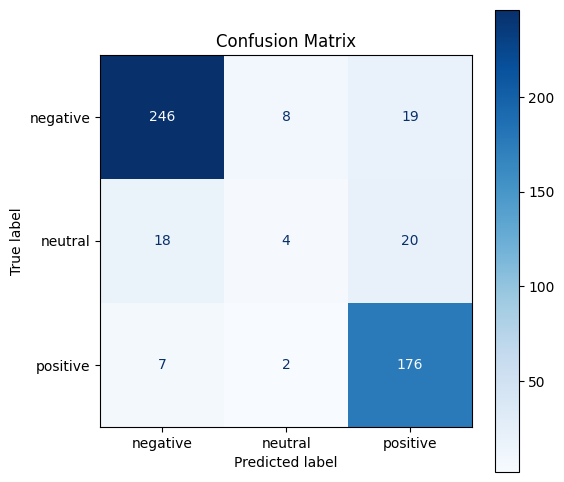

Weighted Precision: 0.8225
Weighted Recall: 0.8520
Weighted F1 Score: 0.8314


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score

y_true = final_df['pred_sentiment'].astype(str).str.lower()
y_pred = final_df['groundtruth'].astype(str).str.lower()

print("\nClassification Report:")
print(classification_report(y_true, y_pred, labels=['negative', 'neutral', 'positive']))

cm = confusion_matrix(y_true, y_pred, labels=['negative', 'neutral', 'positive'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['negative', 'neutral', 'positive'])

fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title("Confusion Matrix")
plt.show()

precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print(f"Weighted Precision: {precision:.4f}")
print(f"Weighted Recall: {recall:.4f}")
print(f"Weighted F1 Score: {f1:.4f}")


### Bert

In [ ]:
MODEL_NAME = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

star_to_sentiment = {
    0: "negative",
    1: "negative",
    2: "neutral",
    3: "positive",
    4: "positive"
}

class SentimentDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length=128):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoded = self.tokenizer(
            self.texts[idx],
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            "input_ids": encoded["input_ids"].squeeze(0),
            "attention_mask": encoded["attention_mask"].squeeze(0)
        }

class SentimentClassifier(pl.LightningModule):
    def __init__(self, model_name):
        super().__init__()
        self.model = AutoModelForSequenceClassification.from_pretrained(model_name)

    def forward(self, input_ids, attention_mask):
        return self.model(input_ids=input_ids, attention_mask=attention_mask)

texts = example_df["cleaned_review"].astype(str).tolist()
dataset = SentimentDataset(texts, tokenizer)
dataloader = DataLoader(dataset, batch_size=128, num_workers=4)

model = SentimentClassifier(MODEL_NAME)

trainer = pl.Trainer(
    accelerator="auto",
    devices="auto",
    precision= 32,
    logger=False,
    enable_checkpointing=False
)

all_results = []
model.eval()

for batch in tqdm(dataloader, desc="Sentiment Inference"):
    batch = {k: v.to(model.device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)
        probs = F.softmax(outputs.logits, dim=1)
        preds = torch.argmax(probs, dim=1)

        for j in range(len(preds)):

            all_results.append({
        "pred_sentiment": star_to_sentiment[preds[j].item()],
        "negative_score": round(probs[j][0].item() + probs[j][1].item(), 4),
        "neutral_score": round(probs[j][2].item(), 4),
        "positive_score": round(probs[j][3].item() + probs[j][4].item(), 4),
    })

results_df = pd.DataFrame(all_results)
df = example_df.reset_index(drop=True)
final_df = pd.concat([df, results_df], axis=1)

# Save output
final_df.to_csv("500_swiggy_reviews_BERT_sentiment.csv", index=False)

print("Lightning-fast inference completed.")
print(final_df.head())

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Sentiment Inference:   0%|          | 0/4 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenize

Lightning-fast inference completed.
      App       review_date  \
0  Swiggy   9/11/2019 14:35   
1  Swiggy  12/30/2019 13:12   
2  Swiggy   10/5/2022 13:43   
3  Swiggy   10/6/2020 11:23   
4  Swiggy    3/3/2020 11:48   

                                  review_description  rating groundtruth  \
0  Just few minutes ago. I installed Swiggy in my...       1    negative   
1  Very very wonderful app it gives daily offer a...       5    positive   
2  Sweegy is a fraude i have paied 1500 inr for a...       1    negative   
3  Horrible service provider Didn't get the food ...       1    negative   
4  Rates are too much than expected. Delivery cha...       3     neutral   

                                  developer_response developer_response_date  \
0  Hey Samiya, we're truly sorry for the ordeal y...         9/11/2019 14:50   
1  Hey, thanks for the rating! This motivates us ...        12/30/2019 13:16   
2  Hi, we are sorry about the sub-par experience ...         10/5/2022 13:51   



Classification Report:
              precision    recall  f1-score   support

    negative       0.91      0.91      0.91       270
     neutral       0.21      0.08      0.12        37
    positive       0.82      0.92      0.87       193

    accuracy                           0.85       500
   macro avg       0.65      0.64      0.63       500
weighted avg       0.82      0.85      0.83       500



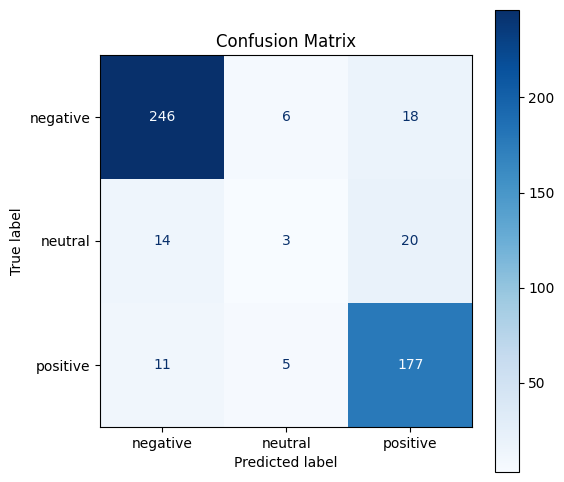

Weighted Precision: 0.8238
Weighted Recall: 0.8520
Weighted F1 Score: 0.8347


In [ ]:
y_true = final_df['pred_sentiment'].astype(str).str.lower()
y_pred = final_df['groundtruth'].astype(str).str.lower()

# Print classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, labels=['negative', 'neutral', 'positive']))

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=['negative', 'neutral', 'positive'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['negative', 'neutral', 'positive'])

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title("Confusion Matrix")
plt.show()

# Optionally, print precision, recall, f1 separately
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print(f"Weighted Precision: {precision:.4f}")
print(f"Weighted Recall: {recall:.4f}")
print(f"Weighted F1 Score: {f1:.4f}")

## Ratings to reviews

### Bert

In [ ]:

MODEL_NAME = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

star_to_sentiment = {
    0: "very negative",
    1: "negative",
    2: "neutral",
    3: "positive",
    4: "very positive"
}

class SentimentDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length=128):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoded = self.tokenizer(
            self.texts[idx],
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            "input_ids": encoded["input_ids"].squeeze(0),
            "attention_mask": encoded["attention_mask"].squeeze(0)
        }

class SentimentClassifier(pl.LightningModule):
    def __init__(self, model_name):
        super().__init__()
        self.model = AutoModelForSequenceClassification.from_pretrained(model_name)

    def forward(self, input_ids, attention_mask):
        return self.model(input_ids=input_ids, attention_mask=attention_mask)

texts = df["cleaned_review"].astype(str).tolist()
dataset = SentimentDataset(texts, tokenizer)
dataloader = DataLoader(dataset, batch_size=128, num_workers=4)

model = SentimentClassifier(MODEL_NAME)

trainer = pl.Trainer(
    accelerator="auto",
    devices="auto",
    precision= 32,
    logger=False,
    enable_checkpointing=False
)

all_results = []
model.eval()

for batch in tqdm(dataloader, desc="Sentiment Inference"):
    batch = {k: v.to(model.device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)
        probs = F.softmax(outputs.logits, dim=1)
        preds = torch.argmax(probs, dim=1)

        for j in range(len(preds)):
            all_results.append({
                "predicted_sentiment": star_to_sentiment[preds[j].item()],
                "very_negative_score": round(probs[j][0].item(), 4),
                "negative_score": round(probs[j][1].item(), 4),
                "neutral_score": round(probs[j][2].item(), 4),
                "positive_score": round(probs[j][3].item(), 4),
                "very_positive_score": round(probs[j][4].item(), 4),
            })

results_df = pd.DataFrame(all_results)
df = df.reset_index(drop=True)
final_df = pd.concat([df, results_df], axis=1)

final_df.to_csv("swiggy_reviews_BERT_sentiment.csv", index=False)

print("Lightning-fast inference completed.")
print(final_df.head())


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Sentiment Inference: 100%|██████████| 737/737 [3:45:37<00:00, 18.37s/it]  


Lightning-fast inference completed.
      App         review_date  \
0  Swiggy 2023-07-24 09:57:40   
1  Swiggy 2023-07-23 10:35:23   
2  Swiggy 2023-07-24 14:48:26   
3  Swiggy 2023-07-07 08:26:00   
4  Swiggy 2023-07-19 07:40:05   

                                  review_description  rating  thumbsUpCount  \
0  I have been using swiggy for a long time and I...       2            104   
1  Worst experiences I'm having with the app for ...       1             13   
2  The best foolishing app with offers. The app o...       1              8   
3  Title: Disappointing Experience with Swiggy In...       1             86   
4  Worst ever experience. I ordered from instamar...       1             30   

                                  developer_response developer_response_date  \
0  Hey there, we apologize for the inconvenience ...     2023-07-24 10:02:21   
1  Hello, we would like to know more about it. Pl...     2023-07-23 10:42:22   
2  We are sorry to let you down. Please write to .

In [ ]:
bert_df = pd.read_csv('/teamspace/studios/this_studio/forecasing_project1/swiggy_reviews_BERT_sentiment.csv')

In [ ]:
sentiment_mapping = {
    'very positive': 'positive',
    'positive': 'positive',
    'very negative': 'negative',
    'negative': 'negative',
    'neutral': 'neutral'
}
bert_df['predicted_sentiment'] = bert_df['predicted_sentiment'].map(sentiment_mapping)


In [ ]:
def map_rating_to_sentiment(rating):
    if rating in [1, 2]:
        return 'negative'
    elif rating == 3:
        return 'neutral'
    elif rating in [4, 5]:
        return 'positive'

bert_df['rating_sentiment'] = bert_df['rating'].apply(map_rating_to_sentiment)


              precision    recall  f1-score   support

    negative       0.93      0.92      0.93     59015
     neutral       0.19      0.32      0.23      3630
    positive       0.91      0.86      0.88     31583

    accuracy                           0.88     94228
   macro avg       0.68      0.70      0.68     94228
weighted avg       0.90      0.88      0.89     94228



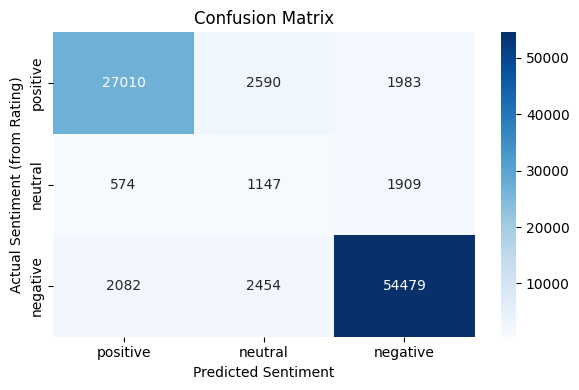

In [ ]:
comparison_df = bert_df.dropna(subset=['predicted_sentiment', 'rating_sentiment'])

y_true = comparison_df['rating_sentiment']
y_pred = comparison_df['predicted_sentiment']

print(classification_report(y_true, y_pred))

conf_matrix = confusion_matrix(y_true, y_pred, labels=['positive', 'neutral', 'negative'])

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['positive', 'neutral', 'negative'],
            yticklabels=['positive', 'neutral', 'negative'])
plt.xlabel('Predicted Sentiment')
plt.ylabel('Actual Sentiment (from Rating)')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

### RoBerta

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name).to(device)
model.eval()
if device.type == "cuda":
    model = model.half()

texts = df["cleaned_review"].astype(str).tolist()

batch_size = 128
labels = ["negative", "neutral", "positive"]
results = []

for i in tqdm(range(0, len(texts), batch_size), desc="Processing"):
    batch_texts = texts[i:i + batch_size]
    try:
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)

        with torch.no_grad():
            outputs = model(**inputs)
            probs = F.softmax(outputs.logits, dim=1)
            preds = torch.argmax(probs, dim=1)

        for j in range(len(batch_texts)):
            results.append({
                "predicted_sentiment": labels[preds[j].item()],
                "negative_score": round(probs[j][0].item(), 4),
                "neutral_score": round(probs[j][1].item(), 4),
                "positive_score": round(probs[j][2].item(), 4)
            })
    except Exception as e:
        for j in range(len(batch_texts)):
            results.append({
                "predicted_sentiment": "error",
                "negative_score": 0,
                "neutral_score": 0,
                "positive_score": 0
            })

results_df = pd.DataFrame(results)

final_df = pd.concat([df.reset_index(drop=True), results_df], axis=1)

final_df.to_csv("swiggy_reviews_sentiment_full.csv", index=False)

print("All done! Full results saved with original columns + sentiment predictions.")
print(final_df.head())


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Processing: 100%|██████████| 737/737 [3:06:48<00:00, 15.21s/it]  


All done! Full results saved with original columns + sentiment predictions.
      App         review_date  \
0  Swiggy 2023-07-24 09:57:40   
1  Swiggy 2023-07-23 10:35:23   
2  Swiggy 2023-07-24 14:48:26   
3  Swiggy 2023-07-07 08:26:00   
4  Swiggy 2023-07-19 07:40:05   

                                  review_description  rating  thumbsUpCount  \
0  I have been using swiggy for a long time and I...       2            104   
1  Worst experiences I'm having with the app for ...       1             13   
2  The best foolishing app with offers. The app o...       1              8   
3  Title: Disappointing Experience with Swiggy In...       1             86   
4  Worst ever experience. I ordered from instamar...       1             30   

                                  developer_response developer_response_date  \
0  Hey there, we apologize for the inconvenience ...     2023-07-24 10:02:21   
1  Hello, we would like to know more about it. Pl...     2023-07-23 10:42:22   
2  We are 

In [ ]:
robert_df = pd.read_csv('/teamspace/studios/this_studio/forecasing_project1/swiggy_reviews_robert_sentiment_full.csv')

In [ ]:
robert_df['rating_sentiment'] = robert_df['rating'].apply(map_rating_to_sentiment)


In [ ]:
robert_df['predicted_sentiment'] = robert_df['predicted_sentiment'].map(sentiment_mapping)

              precision    recall  f1-score   support

    negative       0.93      0.90      0.91     59015
     neutral       0.11      0.25      0.15      3630
    positive       0.94      0.85      0.89     31583

    accuracy                           0.86     94228
   macro avg       0.66      0.66      0.65     94228
weighted avg       0.90      0.86      0.88     94228



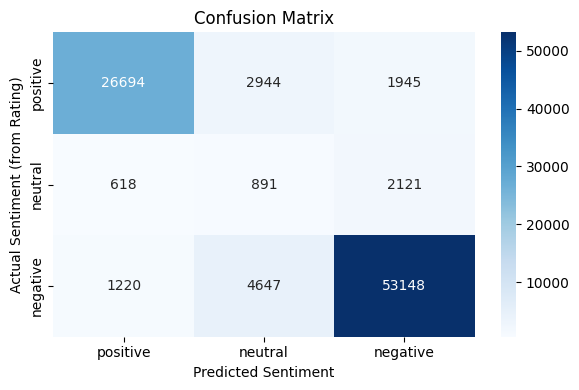

In [ ]:
comparison_df = robert_df.dropna(subset=['predicted_sentiment', 'rating_sentiment'])

y_true = comparison_df['rating_sentiment']
y_pred = comparison_df['predicted_sentiment']

print(classification_report(y_true, y_pred))

conf_matrix = confusion_matrix(y_true, y_pred, labels=['positive', 'neutral', 'negative'])

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['positive', 'neutral', 'negative'],
            yticklabels=['positive', 'neutral', 'negative'])
plt.xlabel('Predicted Sentiment')
plt.ylabel('Actual Sentiment (from Rating)')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

### Distillbert

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch.nn.functional as F
import pandas as pd
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name = "chawki17/My_Sentiment_Analysis_Model"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name).to(device)
model.eval()

id2label = model.config.id2label
labels = [id2label[i] for i in range(len(id2label))]

print("Model Label Mapping:", labels)

texts = df["cleaned_review"].astype(str).tolist()
batch_size = 128
results = []

for i in tqdm(range(0, len(texts), batch_size), desc="Processing"):
    batch_texts = texts[i:i + batch_size]
    try:
        inputs = tokenizer(
            batch_texts,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=256
        ).to(device)

        with torch.no_grad():
            outputs = model(**inputs)
            probs = F.softmax(outputs.logits, dim=1)
            preds = torch.argmax(probs, dim=1)

        for j in range(len(batch_texts)):
            results.append({
                "predicted_sentiment": labels[preds[j].item()],
                "negative_score": round(probs[j][0].item(), 4),
                "neutral_score": round(probs[j][1].item(), 4),
                "positive_score": round(probs[j][2].item(), 4)
            })
    except Exception as e:
        for j in range(len(batch_texts)):
            results.append({
                "predicted_sentiment": "error",
                "negative_score": 0,
                "neutral_score": 0,
                "positive_score": 0
            })

results_df = pd.DataFrame(results)

final_df = pd.concat([df.reset_index(drop=True), results_df], axis=1)

final_df.to_csv("swiggy_reviews_sentiment_distilbert_fixed.csv", index=False)

print("All done! Results saved.")
print(final_df.head())


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Model Label Mapping: ['LABEL_0', 'LABEL_1', 'LABEL_2']


Processing: 100%|██████████| 737/737 [1:32:44<00:00,  7.55s/it]


All done! Results saved.
      App         review_date  \
0  Swiggy 2023-07-24 09:57:40   
1  Swiggy 2023-07-23 10:35:23   
2  Swiggy 2023-07-24 14:48:26   
3  Swiggy 2023-07-07 08:26:00   
4  Swiggy 2023-07-19 07:40:05   

                                  review_description  rating  thumbsUpCount  \
0  I have been using swiggy for a long time and I...       2            104   
1  Worst experiences I'm having with the app for ...       1             13   
2  The best foolishing app with offers. The app o...       1              8   
3  Title: Disappointing Experience with Swiggy In...       1             86   
4  Worst ever experience. I ordered from instamar...       1             30   

                                  developer_response developer_response_date  \
0  Hey there, we apologize for the inconvenience ...     2023-07-24 10:02:21   
1  Hello, we would like to know more about it. Pl...     2023-07-23 10:42:22   
2  We are sorry to let you down. Please write to ...     2023

In [ ]:
Distil_bert = pd.read_csv('/teamspace/studios/this_studio/forecasing_project1/swiggy_reviews_sentiment_distilbert_fixed.csv')

In [ ]:
Distil_bert['predicted_sentiment'].value_counts()

predicted_sentiment
LABEL_2    52817
LABEL_0    35273
LABEL_1     6138
Name: count, dtype: int64

In [ ]:
def map_rating_to_sentiment(rating):
    if rating in [1, 2]:
        return 'negative'
    elif rating == 3:
        return 'neutral'
    elif rating in [4, 5]:
        return 'positive'

Distil_bert['rating_sentiment'] = Distil_bert['rating'].apply(map_rating_to_sentiment)


In [ ]:
label_mapping = {
    'LABEL_2': 'negative',
    'LABEL_0': 'positive',
    'LABEL_1' : 'neutral'
}

Distil_bert['predicted_sentiment'] = Distil_bert['predicted_sentiment'].map(label_mapping).fillna('neutral')


              precision    recall  f1-score   support

    negative       0.84      0.75      0.79     59015
     neutral       0.08      0.13      0.10      3630
    positive       0.65      0.72      0.68     31583

    accuracy                           0.72     94228
   macro avg       0.52      0.53      0.52     94228
weighted avg       0.74      0.72      0.73     94228



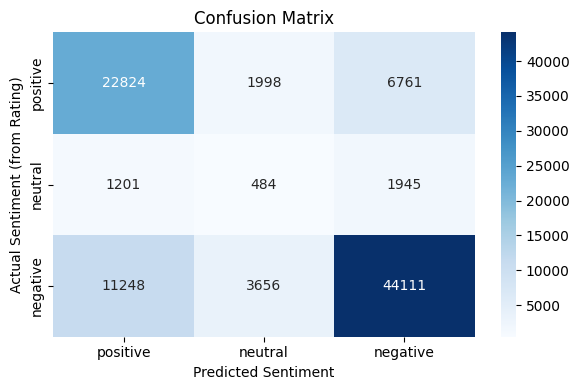

In [ ]:
comparison_df = Distil_bert.dropna(subset=['predicted_sentiment', 'rating_sentiment'])

y_true = comparison_df['rating_sentiment']
y_pred = comparison_df['predicted_sentiment']

print(classification_report(y_true, y_pred))

conf_matrix = confusion_matrix(y_true, y_pred, labels=['positive', 'neutral', 'negative'])

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['positive', 'neutral', 'negative'],
            yticklabels=['positive', 'neutral', 'negative'])
plt.xlabel('Predicted Sentiment')
plt.ylabel('Actual Sentiment (from Rating)')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Sentiment classification

                     DistilBERT   BERT  RoBERTa
predicted_sentiment                            
negative                  52817  58371    57214
neutral                    6138   6191     8482
positive                  35273  29666    28532


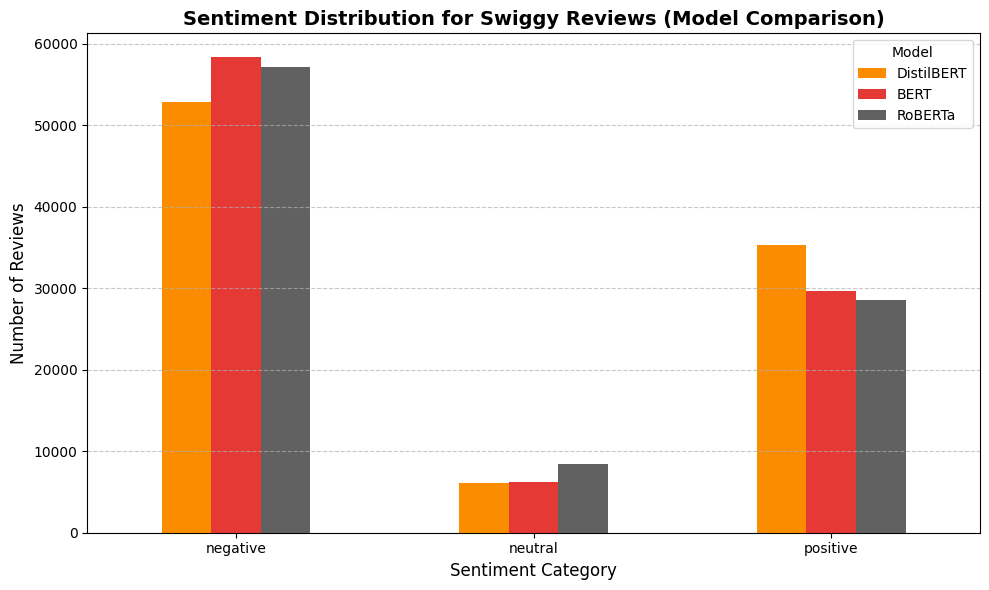

In [ ]:
distil_counts = Distil_bert['predicted_sentiment'].value_counts().rename('DistilBERT')
bert_counts = bert_df['predicted_sentiment'].value_counts().rename('BERT')
robert_counts = robert_df['predicted_sentiment'].value_counts().rename('RoBERTa')

sentiment_comparison = pd.concat([distil_counts, bert_counts, robert_counts], axis=1).fillna(0).astype(int)
sentiment_comparison = sentiment_comparison.reindex(['negative', 'neutral', 'positive'])
print(sentiment_comparison)


swiggy_colors = ['#FB8C00', '#E53935', '#616161']  # light orange, light red, light grey

# Plot
sentiment_comparison.plot(kind='bar', figsize=(10, 6), color=swiggy_colors)

plt.title("Sentiment Distribution for Swiggy Reviews (Model Comparison)", fontsize=14, fontweight='bold')
plt.xlabel("Sentiment Category", fontsize=12)
plt.ylabel("Number of Reviews", fontsize=12)
plt.xticks(rotation=0)
plt.legend(title="Model")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
final_df = pd.read_csv('/teamspace/studios/this_studio/forecasing_project1/swiggy_reviews_BERT_sentiment.csv')

In [ ]:
sentiment_mapping = {
    'very positive': 'positive',
    'positive': 'positive',
    'very negative': 'negative',
    'negative': 'negative',
    'neutral': 'neutral'
}
final_df['predicted_sentiment'] = final_df['predicted_sentiment'].map(sentiment_mapping)


# Aspect Extraction

In [ ]:
!pip install pyLDAvis


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 110.2 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [ ]:

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

final_df['tokens'] = final_df['cleaned_review'].apply(
    lambda text: [w for w in str(text).split() if w.lower() not in stop_words]
)

token_lists = final_df['tokens'].tolist()
dictionary = corpora.Dictionary(token_lists)
dictionary.filter_extremes(no_below=10, no_above=0.5)
corpus = [dictionary.doc2bow(doc) for doc in token_lists]


[nltk_data] Downloading package stopwords to
[nltk_data]     /teamspace/studios/this_studio/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:

num_topics = 5
lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=num_topics,
    passes=10,
    random_state=42
)

coherence_model = CoherenceModel(model=lda_model, texts=token_lists, dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()
print(f" Topic Coherence Score: {coherence_score:.4f}")

print("\nTop Words per Topic:")
for i in range(num_topics):
    print(f"Topic {i}: {[word for word, _ in lda_model.show_topic(i, topn=10)]}")

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis)

topic_to_aspect = {
    0: "customer service",
    1: "app experience",
    2: "delivery",
    3: "food quality",
    4: "Efficiency"
}

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


 Topic Coherence Score: 0.4948

Top Words per Topic:
Topic 0: ['service', 'customer', 'worst', 'app', 'swiggy', 'bad', 'dont', 'care', 'food', 'experience']
Topic 1: ['delivery', 'time', 'charges', 'late', 'much', 'high', 'food', 'zomato', 'location', 'price']
Topic 2: ['swiggy', 'app', 'please', 'one', 'dont', 'give', 'available', 'option', 'cash', 'like']
Topic 3: ['order', 'delivery', 'food', 'ordered', 'swiggy', 'delivered', 'time', 'worst', 'hour', '1']
Topic 4: ['good', 'app', 'food', 'delivery', 'service', 'best', 'nice', 'swiggy', 'fast', 'great']


In [ ]:
def get_dominant_topic(bow):
    topic_probs = lda_model.get_document_topics(bow)
    return max(topic_probs, key=lambda x: x[1])[0]

final_df['dominant_topic'] = [get_dominant_topic(bow) for bow in corpus]
final_df['aspect_lda'] = final_df['dominant_topic'].map(topic_to_aspect)


In [ ]:
final_df.columns

Index(['App', 'review_date', 'review_description', 'rating', 'thumbsUpCount',
       'developer_response', 'developer_response_date', 'appVersion',
       'cleaned_review', 'thumbsUpCount_log', 'predicted_sentiment',
       'very_negative_score', 'negative_score', 'neutral_score',
       'positive_score', 'very_positive_score', 'tokens', 'dominant_topic',
       'aspect_lda'],
      dtype='object')

In [ ]:
sentiment_to_score = {"positive": 1, "neutral": 0, "negative": -1}
final_df['sentiment_score'] = final_df['predicted_sentiment'].map(sentiment_to_score)
final_df['weighted_sentiment'] = final_df['sentiment_score'] * final_df['thumbsUpCount_log']


In [ ]:

final_df['review_length'] = final_df['cleaned_review'].apply(lambda x: len(str(x).split()))
final_df['review_date'] = pd.to_datetime(final_df['review_date'], errors='coerce')
final_df['week'] = final_df['review_date'].dt.to_period('W').apply(lambda r: r.start_time)

agg = (
    final_df
    .groupby(['week', 'aspect_lda'])
    .agg(
        review_count=('aspect_lda', 'size'),
        avg_weighted_sentiment=('weighted_sentiment', 'mean')
    )
    .reset_index()
)

In [ ]:
topic_ratings = final_df.groupby('aspect_lda')['rating'].mean()
print(topic_ratings)

topic_thumbs = final_df.groupby('aspect_lda')['thumbsUpCount'].mean()
print(topic_thumbs)


aspect_lda
Efficiency          4.588501
app experience      2.036823
customer service    1.301869
delivery            2.250760
food quality        1.323378
Name: rating, dtype: float64
aspect_lda
Efficiency          1.507974
app experience      2.184046
customer service    3.498103
delivery            8.197154
food quality        4.197389
Name: thumbsUpCount, dtype: float64


In [ ]:
final_df.to_csv("preprocessed_df.csv", index=False)


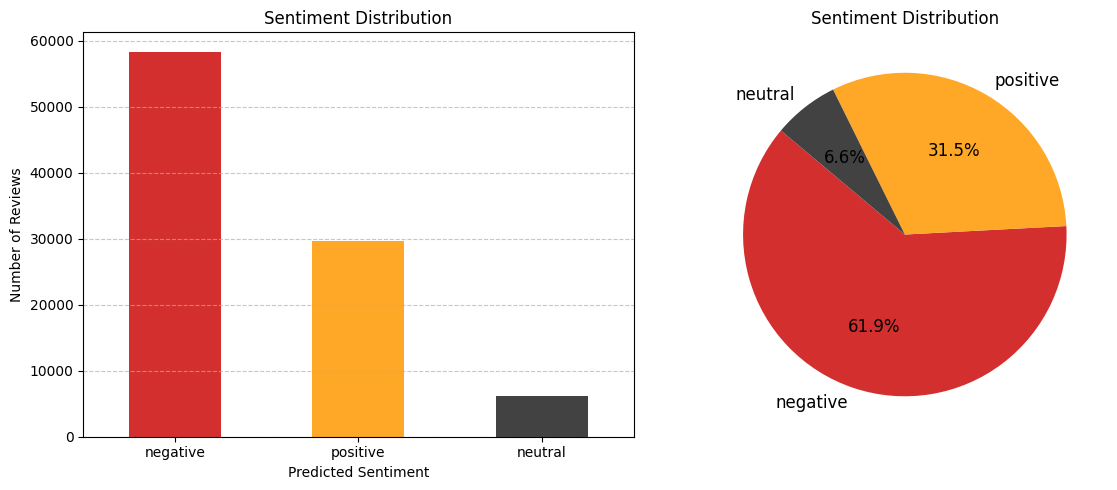

In [ ]:

sentiment_counts = final_df['predicted_sentiment'].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sentiment_counts.plot(kind='bar', color=['#D32F2F', '#FFA726', '#424242'], ax=axes[0])
axes[0].set_title('Sentiment Distribution')
axes[0].set_xlabel('Predicted Sentiment')
axes[0].set_ylabel('Number of Reviews')
axes[0].grid(axis='y', linestyle='--', alpha=0.7)
axes[0].set_xticklabels(sentiment_counts.index, rotation=0)

axes[1].pie(
    sentiment_counts,
    labels=sentiment_counts.index,
    autopct='%1.1f%%',
    colors=['#D32F2F', '#FFA726','#424242'],
    startangle=140,
    textprops={'fontsize': 12}
)
axes[1].set_title('Sentiment Distribution')

plt.tight_layout()
plt.show()


/tmp/ipykernel_975/3079987111.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='aspect_lda', data=final_df, palette=colors_for_plot, ax=axes[0], order=topic_order)
/tmp/ipykernel_975/3079987111.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)


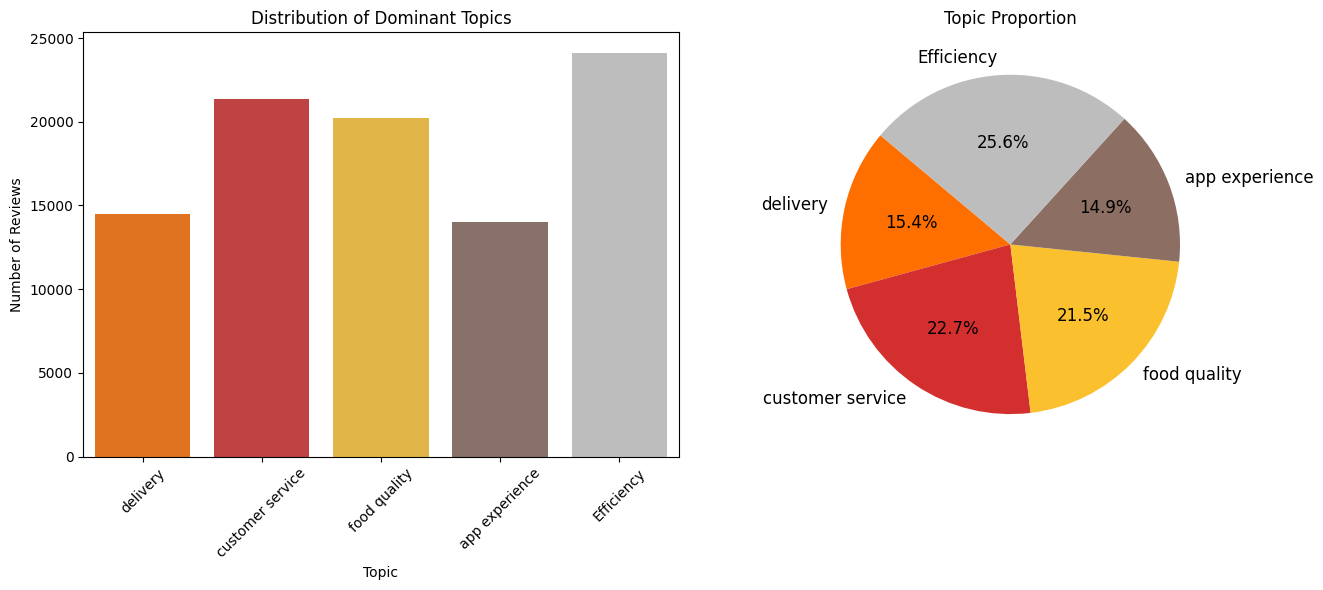

In [ ]:
topic_order = final_df['aspect_lda'].unique()
topic_counts = final_df['aspect_lda'].value_counts().reindex(topic_order)

num_topics = len(topic_order)
custom_colors = [
    '#FF6F00',  # Swiggy Orange (Main color)
    '#D32F2F',  # Swiggy Red (Contrast color)
    '#FBC02D',  # Golden Yellow (Highlight)
    '#8D6E63',  # Earthy Brown (Neutral)
    '#BDBDBD',  # Soft Grey (Neutral tones)
    '#9C27B0',  # Violet (Accent color)
    '#616161',  # Dark Grey (Subtle but bold)
    '#FF7043',  # Light Coral
    '#FFB74D',  # Soft Yellow
    '#0288D1'   # Strong Blue
]
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
colors_for_plot = custom_colors[:num_topics]

sns.countplot(x='aspect_lda', data=final_df, palette=colors_for_plot, ax=axes[0], order=topic_order)
axes[0].set_title('Distribution of Dominant Topics')
axes[0].set_xlabel('Topic')
axes[0].set_ylabel('Number of Reviews')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)

axes[1].pie(
    topic_counts.values,
    labels=topic_counts.index,
    autopct='%1.1f%%',
    colors=colors_for_plot,
    startangle=140,
    textprops={'fontsize': 12}
)
axes[1].set_title('Topic Proportion')

plt.tight_layout()
plt.show()


In [ ]:
final_df['predicted_sentiment'].value_counts()

predicted_sentiment
negative    58371
positive    29666
neutral      6191
Name: count, dtype: int64

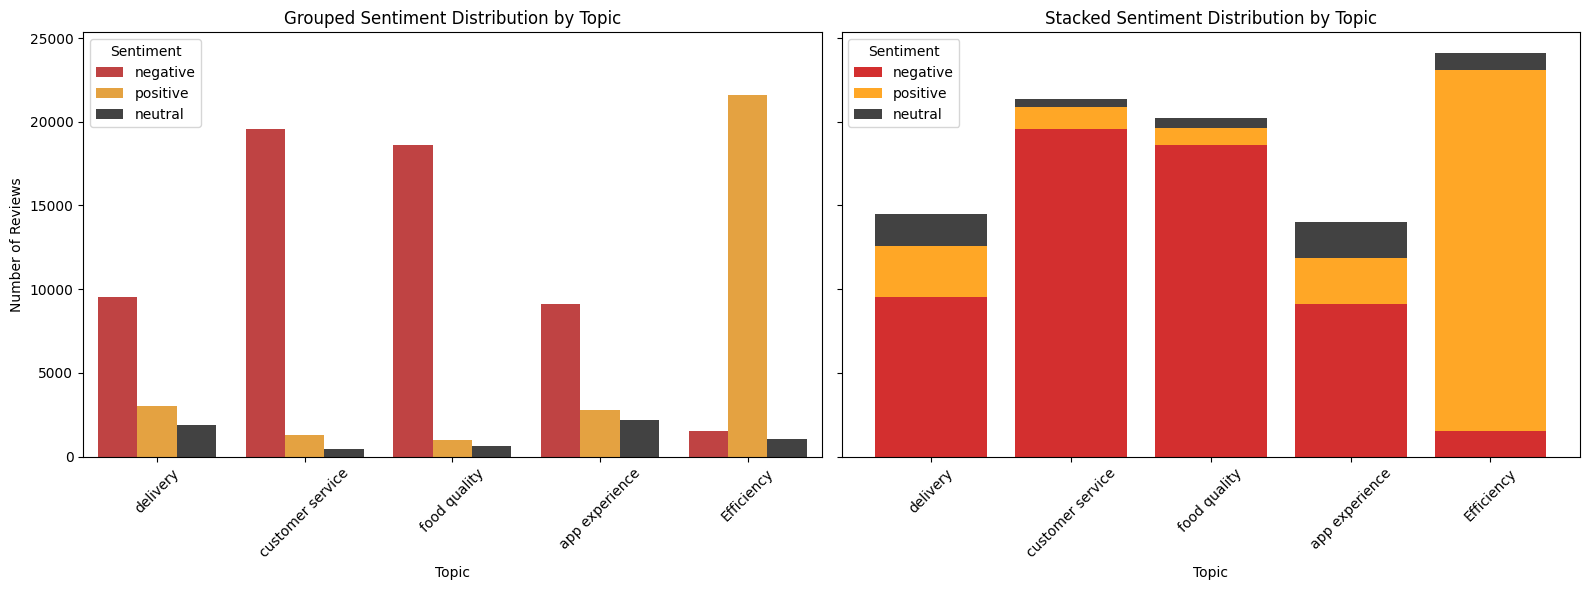

In [ ]:
custom_palette = {
    'positive': '#FFA726',  # Orange
    'negative': '#D32F2F',  # Red
    'neutral': '#424242'    # Grey
}

topic_order = final_df['aspect_lda'].unique()

pivot_df = final_df.pivot_table(
    index='aspect_lda',
    columns='predicted_sentiment',
    aggfunc='size',
    fill_value=0
).reindex(index=topic_order)

for sentiment in ['negative', 'positive', 'neutral']:
    if sentiment not in pivot_df.columns:
        pivot_df[sentiment] = 0
pivot_df = pivot_df[['negative', 'positive', 'neutral']]

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

sns.countplot(
    x='aspect_lda',
    hue='predicted_sentiment',
    data=final_df,
    palette=custom_palette,
    order=topic_order,
    ax=axes[0]
)
axes[0].set_title('Grouped Sentiment Distribution by Topic')
axes[0].set_xlabel('Topic')
axes[0].set_ylabel('Number of Reviews')
axes[0].legend(title='Sentiment')
axes[0].tick_params(axis='x', rotation=45)

bottom_vals = [0] * len(pivot_df)
x = pivot_df.index

for sentiment in ['negative', 'positive', 'neutral']:
    values = pivot_df[sentiment].values
    axes[1].bar(x, values, bottom=bottom_vals, label=sentiment, color=custom_palette[sentiment])
    bottom_vals = [i + j for i, j in zip(bottom_vals, values)]

axes[1].set_title('Stacked Sentiment Distribution by Topic')
axes[1].set_xlabel('Topic')
axes[1].legend(title='Sentiment')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

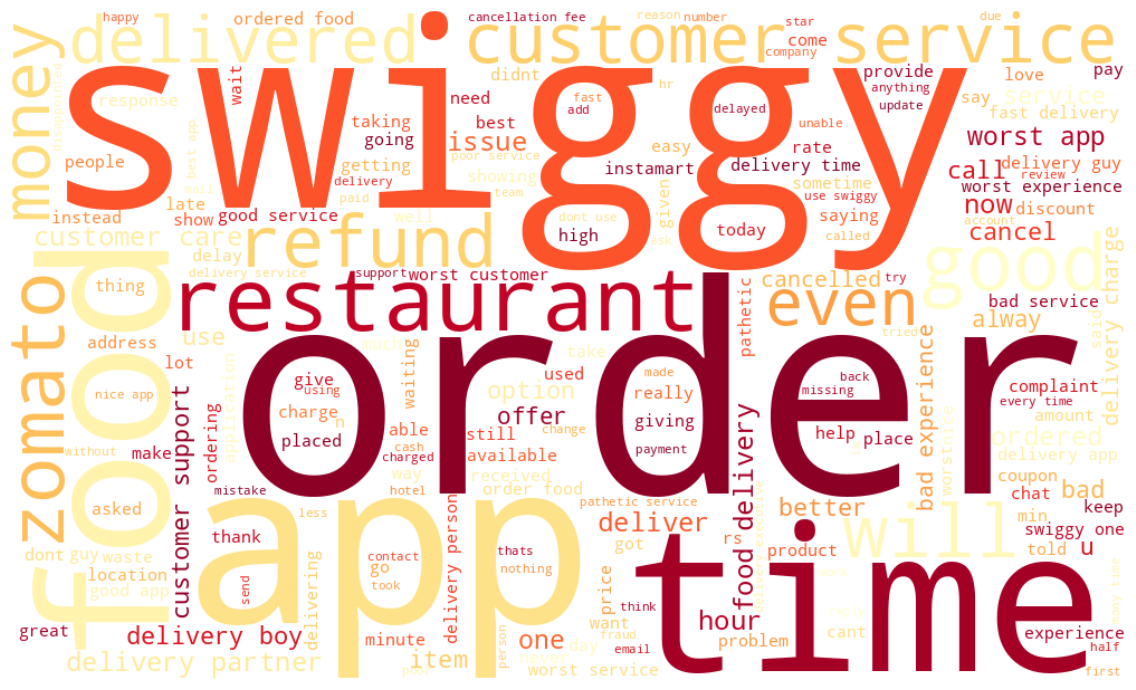

In [ ]:
from wordcloud import WordCloud

text_data = " ".join(str(review) for review in final_df['cleaned_review'].dropna())

wordcloud = WordCloud(
    width=1000,
    height=600,
    background_color='white',
    colormap='YlOrRd',
    contour_width=1,
    contour_color='steelblue'
).generate(text_data)


plt.figure(figsize=(12, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout()
plt.show()


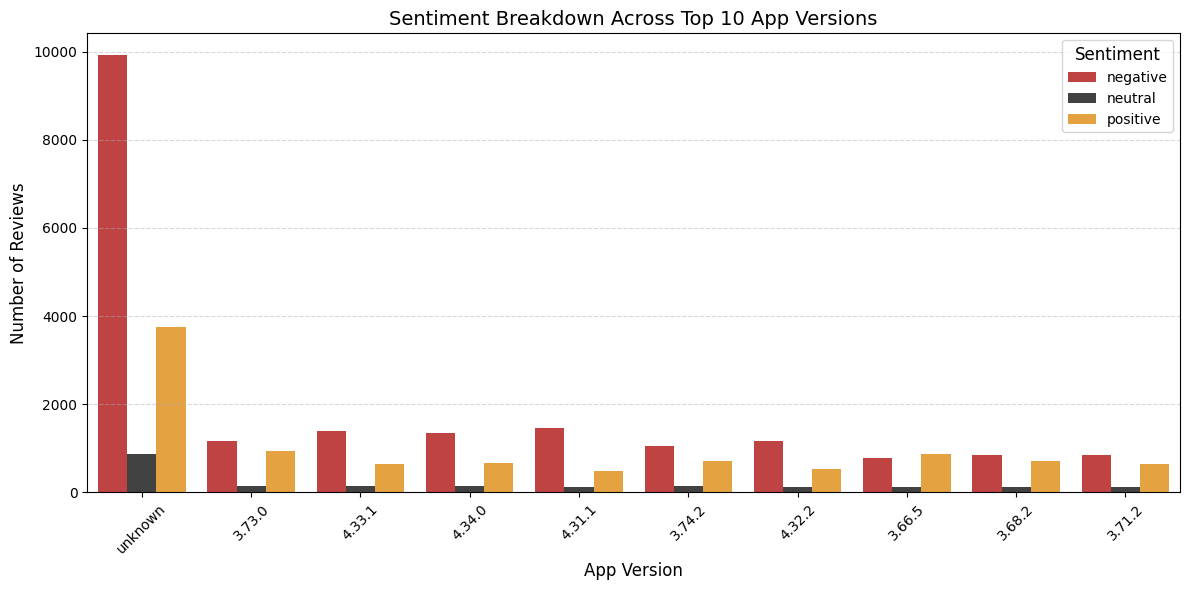

In [ ]:

custom_palette = {
    'positive': '#FFA726',  # Swiggy Orange (strong and energetic)
    'negative': '#D32F2F',  # Deep Red (alert and negative tone)
    'neutral': '#424242'    # Charcoal Grey (balanced and neutral)
}

top_versions = final_df['appVersion'].value_counts().nlargest(10).index
filtered_df = final_df[final_df['appVersion'].isin(top_versions)]

sorted_versions = filtered_df['appVersion'].value_counts().loc[top_versions].index

plt.figure(figsize=(12, 6))
sns.countplot(
    data=filtered_df,
    x='appVersion',
    hue='predicted_sentiment',
    order=sorted_versions,
    palette=custom_palette
)

plt.title('Sentiment Breakdown Across Top 10 App Versions', fontsize=14)
plt.xlabel('App Version', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Sentiment', title_fontsize=12)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


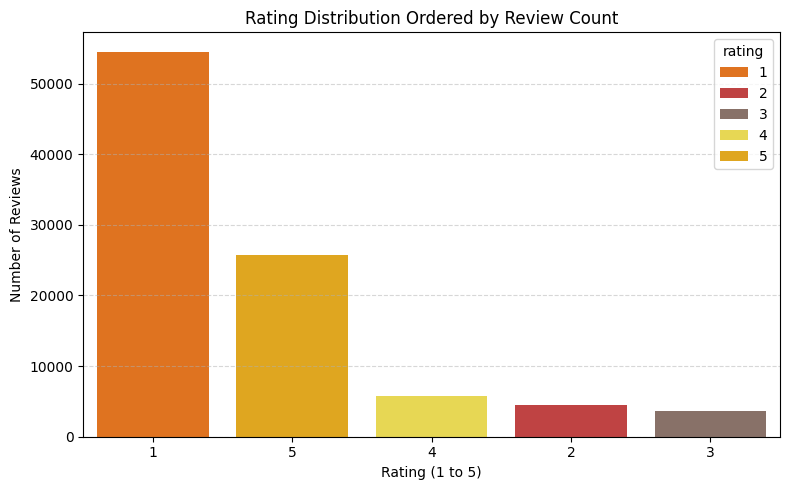

In [ ]:
custom_colors = [
    '#FF6F00',  # Swiggy Orange
    '#D32F2F',  # Swiggy Red (Contrast color)
    '#8D6E63',  # Earthy Brown
    '#FFEB3B',  # Golden Yellow
    '#FFB300'
]

rating_counts = final_df['rating'].value_counts().sort_values(ascending=False)
ordered_ratings = rating_counts.index

plt.figure(figsize=(8, 5))
sns.countplot(x='rating', data=final_df, hue='rating', order=ordered_ratings, palette=custom_colors)

plt.title('Rating Distribution Ordered by Review Count')
plt.xlabel('Rating (1 to 5)')
plt.ylabel('Number of Reviews')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Using the preprocessed dataaset

In [6]:
final_df = pd.read_csv('/teamspace/studios/this_studio/forecasing_project1/preprocessed_df.csv')

In [ ]:
final_df.tail()

,App,review_date,review_description,rating,thumbsUpCount,developer_response,developer_response_date,appVersion,cleaned_review,thumbsUpCount_log,...,negative_score,neutral_score,positive_score,very_positive_score,tokens,dominant_topic,aspect_lda,sentiment_score,weighted_sentiment,week
94223,Swiggy,2021-09-14 18:50:51,Worst app as well as the uneducated customer s...,1,1,"Hi, we are sorry about this. Please help us wi...",2021-09-14 18:51:57,3.74.2,worst app as well as the uneducated customer s...,0.693147,...,0.1753,0.0197,0.0014,0.0006,"['worst', 'app', 'well', 'uneducated', 'custom...",0,customer service,-1,-0.693147,2021-09-13
94224,Swiggy,2021-03-20 17:20:25,Swiggy rider are very slow,1,1,"Hi Dhierndra, we understand your disappointmen...",2021-03-20 17:23:00,unknown,swiggy rider are very slow,0.693147,...,0.4471,0.2159,0.0212,0.0053,"['swiggy', 'rider', 'slow']",1,app experience,-1,-0.693147,2021-03-15
94225,Swiggy,2021-01-19 15:50:33,Pathetic service. No delivery after 1 hour,1,1,"Hi Dinesh, we completely understand that we ha...",2021-01-19 15:56:24,3.53.1,pathetic service no delivery after 1 hour,0.693147,...,0.0766,0.0090,0.0009,0.0005,"['pathetic', 'service', 'delivery', '1', 'hour']",3,food quality,-1,-0.693147,2021-01-18
94226,Swiggy,2021-06-01 17:53:47,Today I can't receive my order....very very ba...,1,1,"Hi Niladri, we are sorry if we have missed the...",2021-06-01 18:02:47,3.52.0,today i cant receive my ordervery very bad ser...,0.693147,...,0.1670,0.0547,0.0102,0.0093,"['today', 'cant', 'receive', 'ordervery', 'bad...",3,food quality,-1,-0.693147,2021-05-31
94227,Swiggy,2021-04-06 16:32:55,Worst app . Out of stock ... Is the only compl...,1,1,"Hi Gayathri, we hear your disappointment towar...",2021-04-06 16:45:42,3.63.0,worst app out of stock is the only complaint,0.693147,...,0.1272,0.0187,0.0023,0.0013,"['worst', 'app', 'stock', 'complaint']",0,customer service,-1,-0.693147,2021-04-05


In [ ]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94228 entries, 0 to 94227
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   App                      94228 non-null  object 
 1   review_date              94228 non-null  object 
 2   review_description       94228 non-null  object 
 3   rating                   94228 non-null  int64  
 4   thumbsUpCount            94228 non-null  int64  
 5   developer_response       93574 non-null  object 
 6   developer_response_date  93574 non-null  object 
 7   appVersion               94228 non-null  object 
 8   cleaned_review           94220 non-null  object 
 9   thumbsUpCount_log        94228 non-null  float64
 10  predicted_sentiment      94228 non-null  object 
 11  negative_score           94228 non-null  float64
 12  neutral_score            94228 non-null  float64
 13  positive_score           94228 non-null  float64
 14  tokens                

In [7]:
final_df['review_date'] = pd.to_datetime(final_df['review_date'])


In [8]:
weekly_sentiment = final_df.resample('W', on='review_date')['weighted_sentiment'].mean().reset_index()
Daily_sentiment = final_df.resample('D', on='review_date')['weighted_sentiment'].mean().reset_index()
daily_sentiment_12h = final_df.resample('12H', on='review_date')['weighted_sentiment'].mean().reset_index()


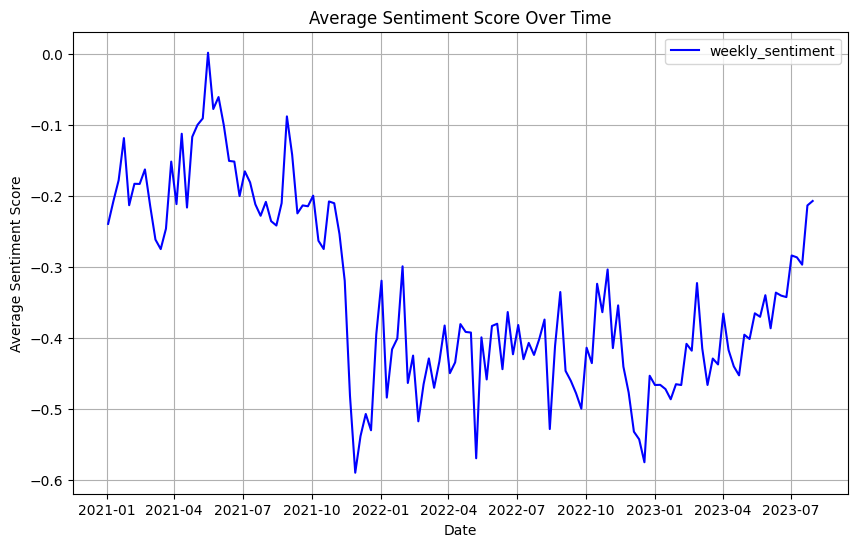

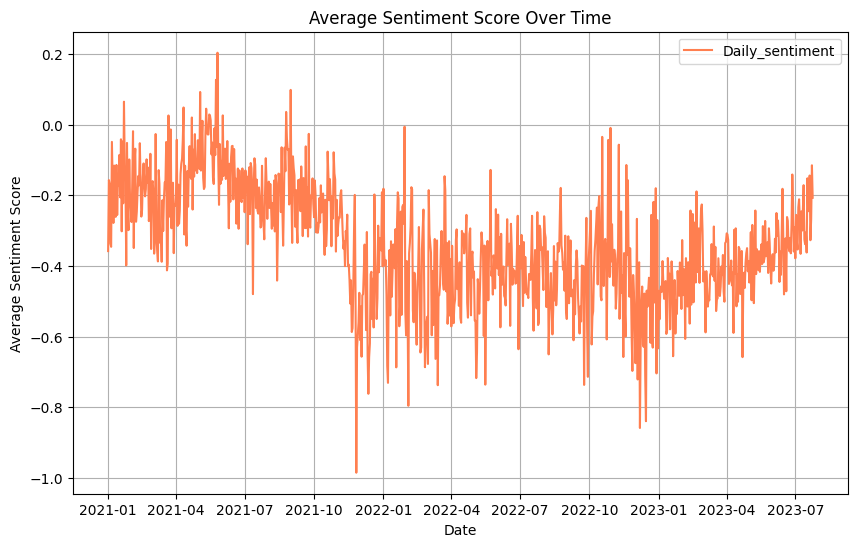

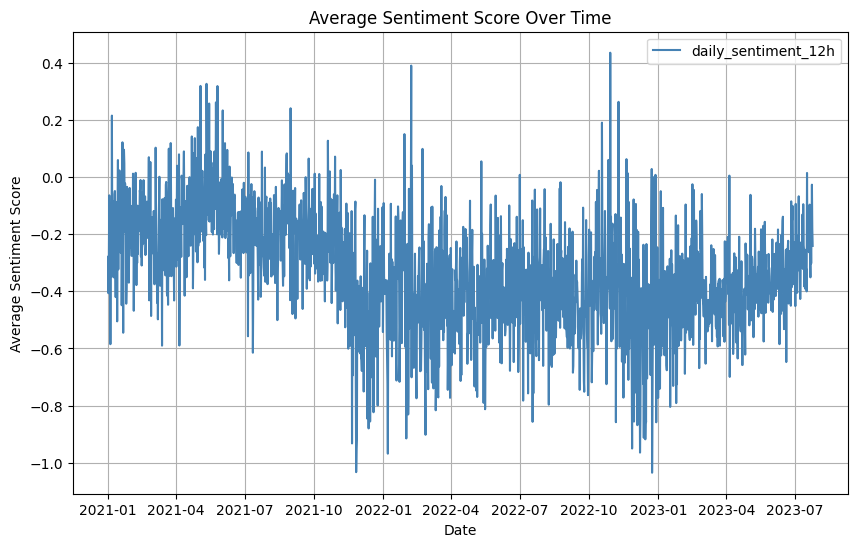

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(weekly_sentiment['review_date'], weekly_sentiment['weighted_sentiment'], label='weekly_sentiment', color='blue')

plt.xlabel('Date')
plt.ylabel('Average Sentiment Score')
plt.title('Average Sentiment Score Over Time')
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(10, 6))

plt.plot(Daily_sentiment['review_date'], Daily_sentiment['weighted_sentiment'], label='Daily_sentiment', color='coral')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Score')
plt.title('Average Sentiment Score Over Time')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))

plt.plot(daily_sentiment_12h['review_date'], daily_sentiment_12h['weighted_sentiment'], label='daily_sentiment_12h', color='steelblue')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Score')
plt.title('Average Sentiment Score Over Time')
plt.legend()
plt.grid(True)
plt.show()


# Aspect Wise sentiment Analysis

In [11]:

aspect_names = final_df['aspect_lda'].unique()

for aspect in aspect_names:
    aspect_var_name = aspect.replace(" ", "_") + "_df"

    aspect_df = final_df[final_df['aspect_lda'] == aspect].copy().reset_index(drop=True)

    globals()[aspect_var_name] = aspect_df



In [ ]:
print(delivery_df.shape)
print(app_experience_df.shape)
print(customer_service_df.shape)
print(food_quality_df.shape)
print(Efficiency_df.shape)

(14476, 23)
(14040, 23)
(21347, 23)
(20224, 23)
(24141, 23)


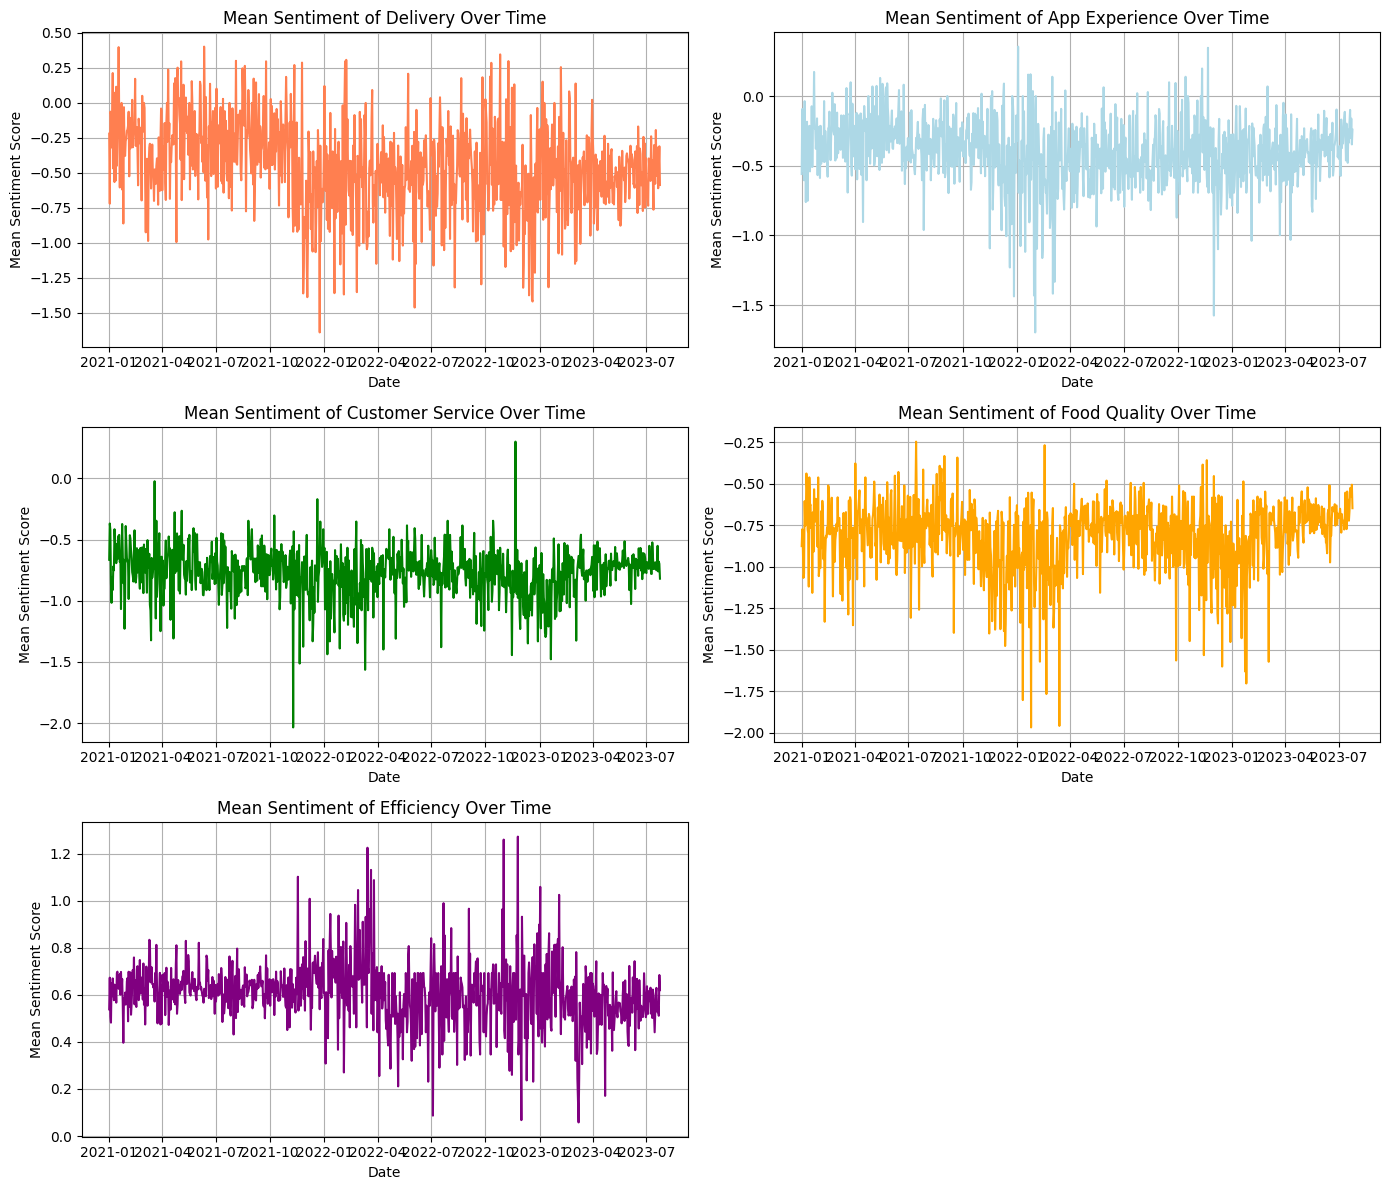

In [12]:
delivery_df['review_date'] = pd.to_datetime(delivery_df['review_date'])
app_experience_df['review_date'] = pd.to_datetime(app_experience_df['review_date'])
customer_service_df['review_date'] = pd.to_datetime(customer_service_df['review_date'])
food_quality_df['review_date'] = pd.to_datetime(food_quality_df['review_date'])
Efficiency_df['review_date'] = pd.to_datetime(Efficiency_df['review_date'])

delivery_daily = delivery_df.groupby(delivery_df['review_date'].dt.date)['weighted_sentiment'].mean()
app_experience_daily = app_experience_df.groupby(app_experience_df['review_date'].dt.date)['weighted_sentiment'].mean()
customer_service_daily = customer_service_df.groupby(customer_service_df['review_date'].dt.date)['weighted_sentiment'].mean()
food_quality_daily = food_quality_df.groupby(food_quality_df['review_date'].dt.date)['weighted_sentiment'].mean()
Efficiency_daily =Efficiency_df.groupby(Efficiency_df['review_date'].dt.date)['weighted_sentiment'].mean()

fig, axes = plt.subplots(3, 2, figsize=(14, 12))

axes[0, 0].plot(delivery_daily.index, delivery_daily.values, color='coral')
axes[0, 0].set_title('Mean Sentiment of Delivery Over Time')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Mean Sentiment Score')
axes[0, 0].grid(True)

axes[0, 1].plot(app_experience_daily.index, app_experience_daily.values, color='lightblue')
axes[0, 1].set_title('Mean Sentiment of App Experience Over Time')
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Mean Sentiment Score')
axes[0, 1].grid(True)

axes[1, 0].plot(customer_service_daily.index, customer_service_daily.values, color='green')
axes[1, 0].set_title('Mean Sentiment of Customer Service Over Time')
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Mean Sentiment Score')
axes[1, 0].grid(True)

axes[1, 1].plot(food_quality_daily.index, food_quality_daily.values, color='orange')
axes[1, 1].set_title('Mean Sentiment of Food Quality Over Time')
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('Mean Sentiment Score')
axes[1, 1].grid(True)

axes[2, 0].plot(Efficiency_daily.index, Efficiency_daily.values, color='purple')
axes[2, 0].set_title('Mean Sentiment of Efficiency Over Time')
axes[2, 0].set_xlabel('Date')
axes[2, 0].set_ylabel('Mean Sentiment Score')
axes[2, 0].grid(True)

axes[2, 1].axis('off')

plt.tight_layout()
plt.show()

# Statistical Models


Checking for Delivery...


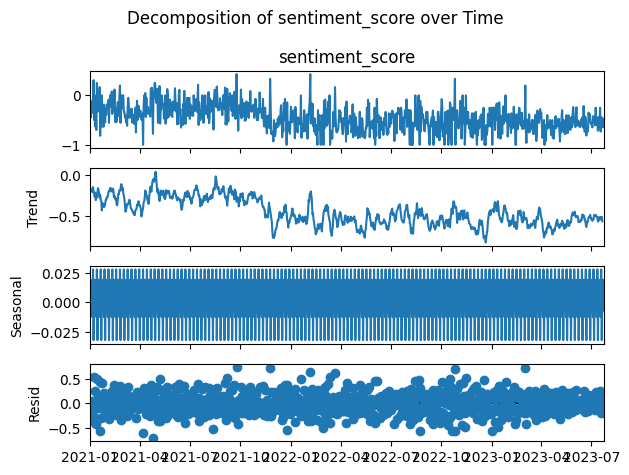

ADF Statistic for sentiment_score: -2.8646883656058177
P-value for sentiment_score: 0.04961104864234729
sentiment_score is stationary (p-value <= 0.05)

Checking for App Experience...


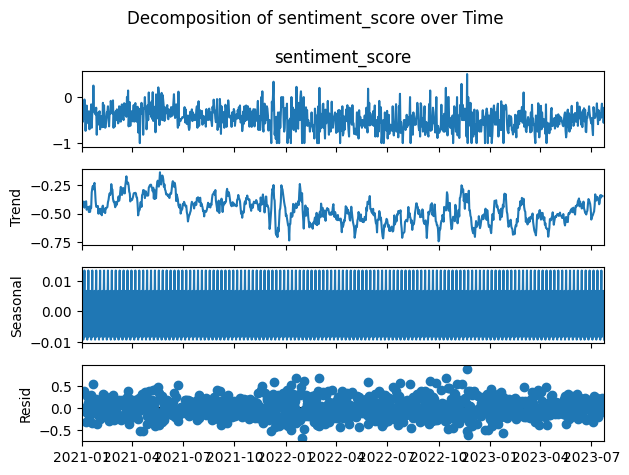

ADF Statistic for sentiment_score: -4.214999134356172
P-value for sentiment_score: 0.0006214206362032717
sentiment_score is stationary (p-value <= 0.05)

Checking for Customer Service...


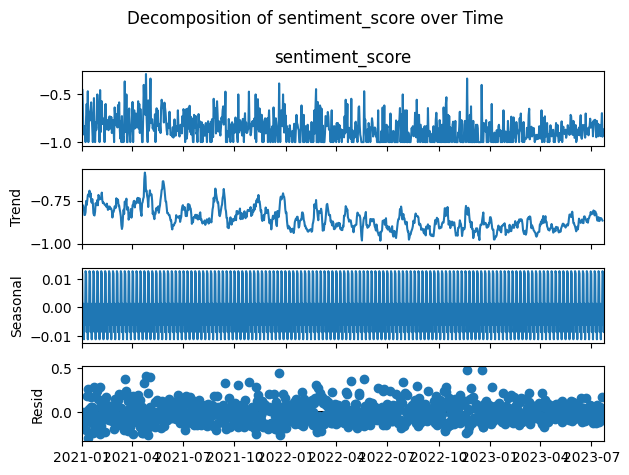

ADF Statistic for sentiment_score: -5.521369602237057
P-value for sentiment_score: 1.8743712783402794e-06
sentiment_score is stationary (p-value <= 0.05)

Checking for Food Quality...


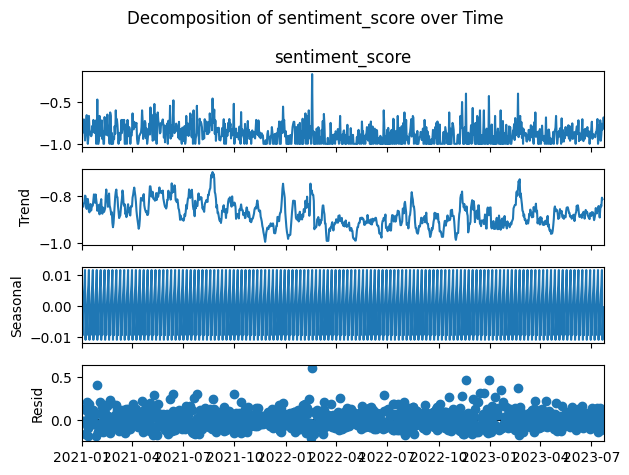

ADF Statistic for sentiment_score: -3.762556961477258
P-value for sentiment_score: 0.0033144972443769484
sentiment_score is stationary (p-value <= 0.05)

Checking for Efficiency...


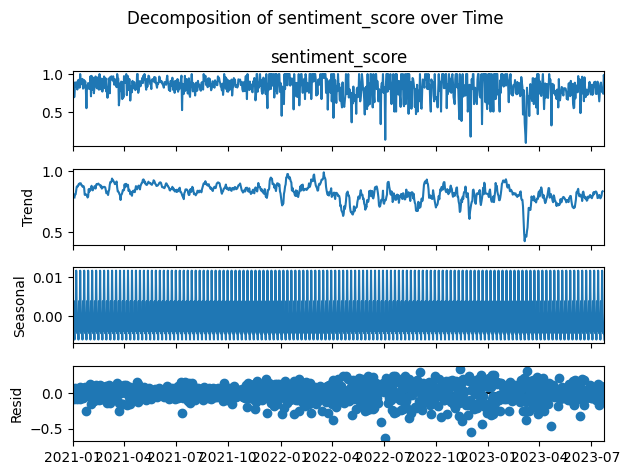

ADF Statistic for sentiment_score: -5.536975924968802
P-value for sentiment_score: 1.7358623742012445e-06
sentiment_score is stationary (p-value <= 0.05)


In [ ]:
def check_stationarity_and_decompose(df, column='sentiment_score', date_column='review_date'):
    df[date_column] = pd.to_datetime(df[date_column])

    df_daily = df.groupby(df[date_column].dt.date)[column].mean()

    decomposition = seasonal_decompose(df_daily, model='additive', period=7)

    decomposition.plot()
    plt.suptitle(f'Decomposition of {column} over Time')
    plt.tight_layout()
    plt.show()

    adf_test = adfuller(df_daily)

    print(f"ADF Statistic for {column}: {adf_test[0]}")
    print(f"P-value for {column}: {adf_test[1]}")

    if adf_test[1] <= 0.05:
        print(f"{column} is stationary (p-value <= 0.05)")
    else:
        print(f"{column} is not stationary (p-value > 0.05)")

dfs = {
    'Delivery': delivery_df,
    'App Experience': app_experience_df,
    'Customer Service': customer_service_df,
    'Food Quality': food_quality_df,
    'Efficiency': Efficiency_df
}

for name, df in dfs.items():
    print(f"\nChecking for {name}...")
    check_stationarity_and_decompose(df)


Plotting ACF and PACF for Delivery...


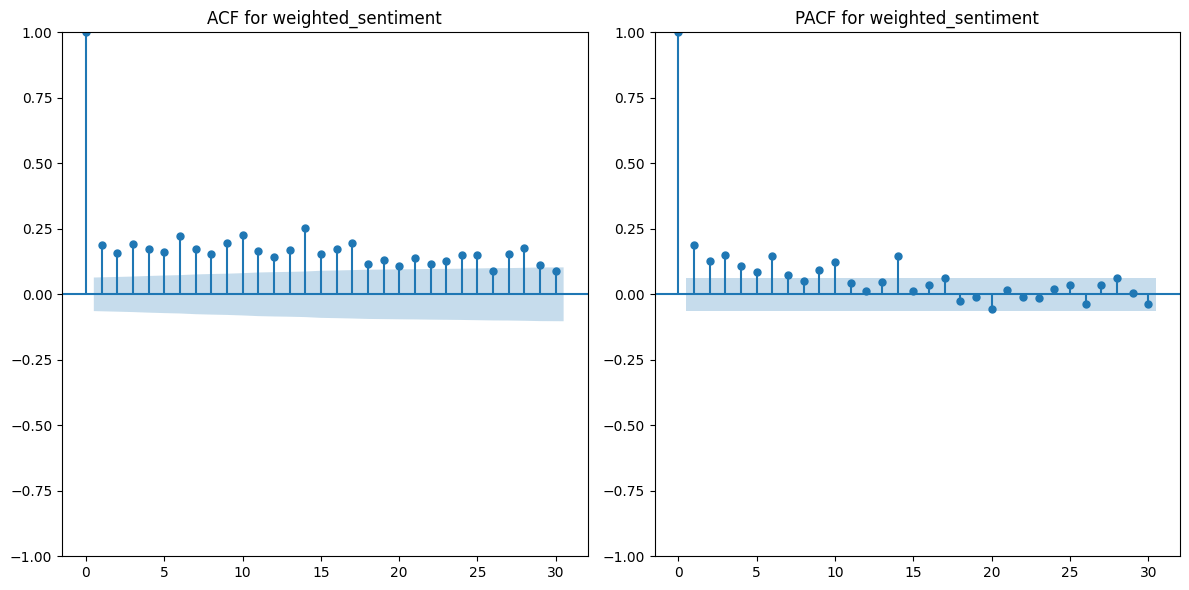


Plotting ACF and PACF for App Experience...


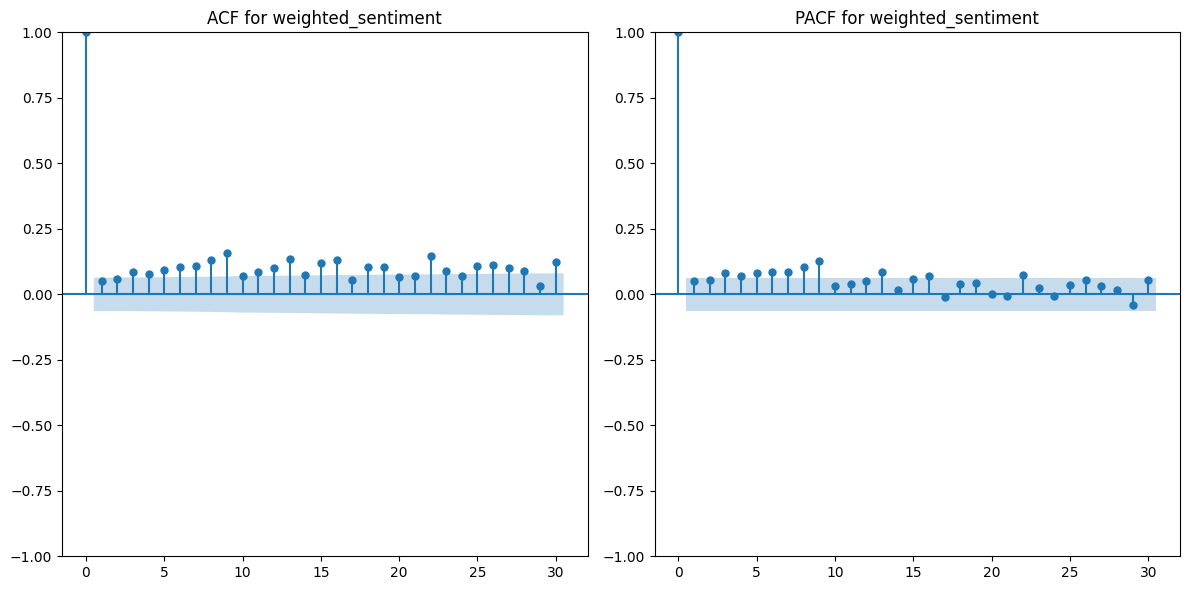


Plotting ACF and PACF for Customer Service...


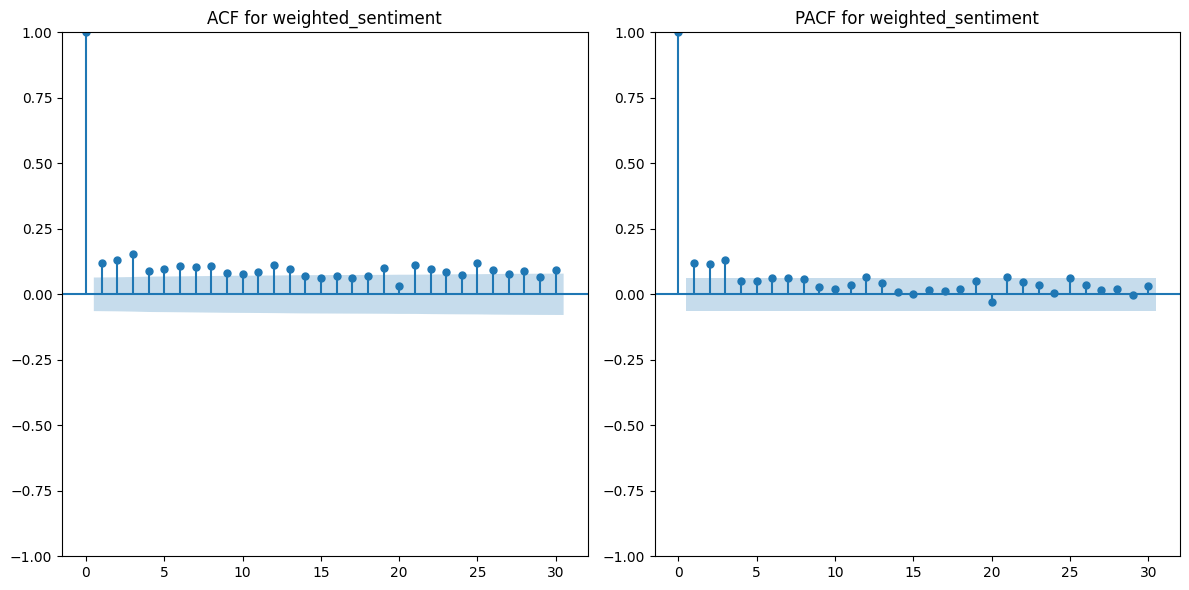


Plotting ACF and PACF for Food Quality...


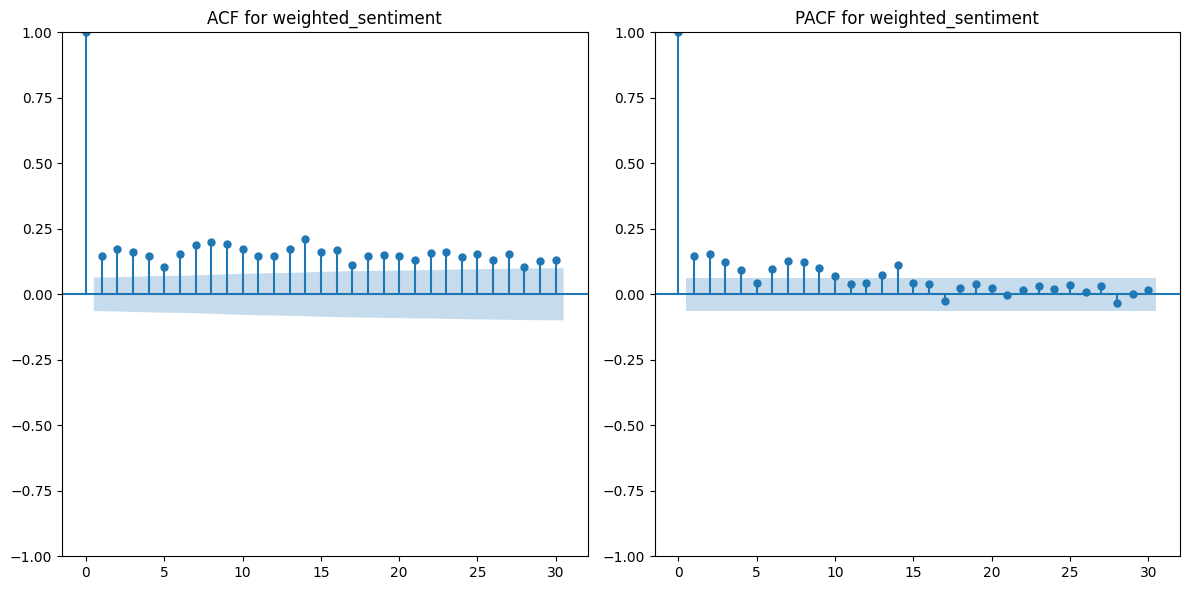


Plotting ACF and PACF for Efficiency...


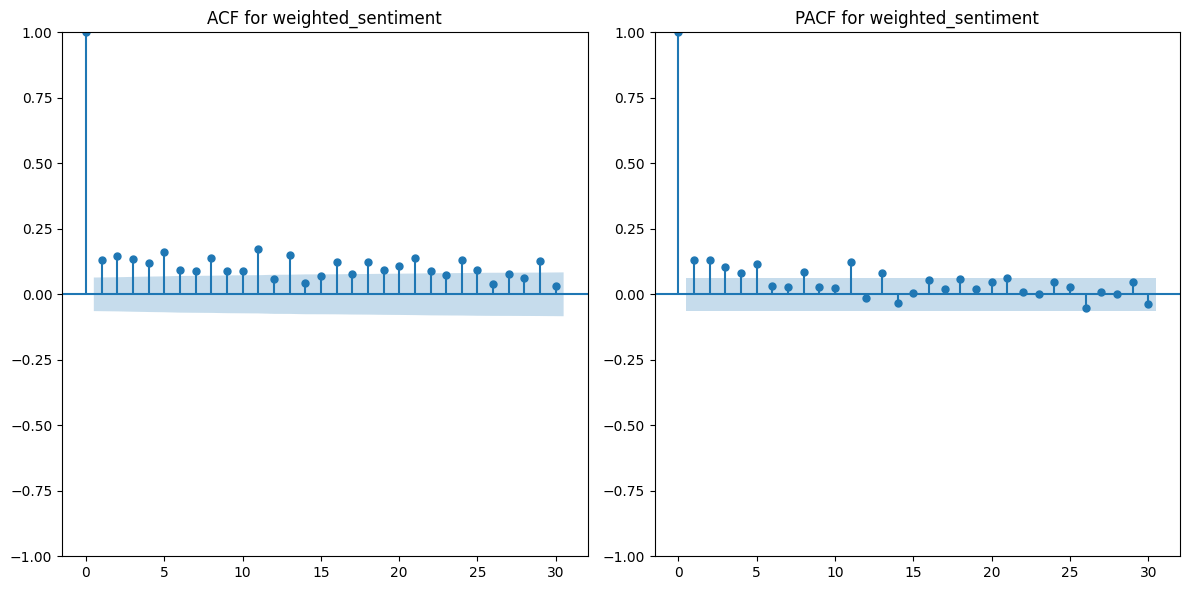

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def plot_acf_pacf(df, column='weighted_sentiment', date_column='review_date'):
    df[date_column] = pd.to_datetime(df[date_column])

    df_daily = df.groupby(df[date_column].dt.date)[column].mean()

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plot_acf(df_daily, lags=30, ax=plt.gca(), title=f'ACF for {column}')

    plt.subplot(1, 2, 2)
    plot_pacf(df_daily, lags=30, ax=plt.gca(), title=f'PACF for {column}')

    plt.tight_layout()
    plt.show()

dfs = {
    'Delivery': delivery_df,
    'App Experience': app_experience_df,
    'Customer Service': customer_service_df,
    'Food Quality': food_quality_df,
    'Efficiency': Efficiency_df
}

for name, df in dfs.items():
    print(f"\nPlotting ACF and PACF for {name}...")
    plot_acf_pacf(df)

# Model Implementation Aspect-Wise

##  VAR model

In [ ]:
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def apply_var_model(df, target_col='weighted_sentiment', lags=12, split_ratio=0.85):
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("DataFrame must have a DatetimeIndex")

    df = df.select_dtypes(include=[np.number]).dropna()

    if target_col not in df.columns:
        raise ValueError(f"'{target_col}' not found in the DataFrame")

    split_point = int(len(df) * split_ratio)
    train, test = df.iloc[:split_point], df.iloc[split_point:]

    model = VAR(train)
    model_fitted = model.fit(lags)
    forecast_input = train.values[-lags:]
    forecast_steps = len(test)
    forecast = model_fitted.forecast(y=forecast_input, steps=forecast_steps)
    forecast_df = pd.DataFrame(forecast, index=test.index, columns=df.columns)

    y_true = test[target_col]
    y_pred = forecast_df[target_col]

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"VAR model fitted to predict '{target_col}'.")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE:  {mae:.4f}")
    print(f"R2 Score: {r2:.4f}")

    return model_fitted, train, test, forecast_df, rmse, mae, r2


In [13]:
def prepare_daily_sentiment_df(df):
    df['review_date'] = pd.to_datetime(df['review_date'])

    daily_df = df.groupby('review_date')[['weighted_sentiment', 'rating', 'thumbsUpCount_log']].mean()

    daily_df = daily_df.dropna()

    return daily_df


delivery_daily = prepare_daily_sentiment_df(delivery_df)
app_experience_daily = prepare_daily_sentiment_df(app_experience_df)
customer_service_daily = prepare_daily_sentiment_df(customer_service_df)
Efficiency_daily = prepare_daily_sentiment_df(Efficiency_df)
food_quality_daily = prepare_daily_sentiment_df(food_quality_df)


In [ ]:
model_fitted, train, test, forecast_df, rmse, mae, r2 = apply_var_model(delivery_daily, target_col='weighted_sentiment', lags=10)


VAR model fitted to predict 'weighted_sentiment'.
RMSE: 0.8507
MAE:  0.5634
R2 Score: -0.0058


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [ ]:
model_fitted, train, test, forecast_df, rmse, mae, r2= apply_var_model(app_experience_daily, target_col='weighted_sentiment', lags=7)


VAR model fitted to predict 'weighted_sentiment'.
RMSE: 0.6887
MAE:  0.5305
R2 Score: -0.0021


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [ ]:
model_fitted, train, test, forecast_df, rmse, mae, r2 = apply_var_model(customer_service_daily, target_col='weighted_sentiment', lags=8)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


VAR model fitted to predict 'weighted_sentiment'.
RMSE: 0.6306
MAE:  0.2686
R2 Score: -0.0109


In [ ]:
model_fitted, train, test, forecast_df, rmse, mae, r2= apply_var_model(Efficiency_daily, target_col='weighted_sentiment', lags=5)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


VAR model fitted to predict 'weighted_sentiment'.
RMSE: 0.4385
MAE:  0.2192
R2 Score: -0.0184


In [ ]:
model_fitted, train, test, forecast_df, rmse, mae, r2 = apply_var_model(food_quality_daily, target_col='weighted_sentiment', lags=5)

VAR model fitted to predict 'weighted_sentiment'.
RMSE: 0.5509
MAE:  0.2844
R2 Score: -0.0437


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


## ARIMAX

In [ ]:
def apply_arimax_model(df, target_col='weighted_sentiment', exog_cols=['rating', 'thumbsUpCount_log'],
                       p=1, d=0, q=1, split_ratio=0.85):
    if not isinstance(df.index, pd.DatetimeIndex):
        if 'review_date' in df.columns:
            df['review_date'] = pd.to_datetime(df['review_date'])
            df.set_index('review_date', inplace=True)
        elif 'delivery_date' in df.columns:
            df['delivery_date'] = pd.to_datetime(df['delivery_date'])
            df.set_index('delivery_date', inplace=True)
        else:
            raise ValueError("DataFrame must have a DatetimeIndex (review_date or delivery_date)")

    df = df[[target_col] + exog_cols].dropna()

    split_point = int(len(df) * split_ratio)
    train, test = df.iloc[:split_point], df.iloc[split_point:]

    y_train, y_test = train[target_col], test[target_col]
    exog_train, exog_test = train[exog_cols], test[exog_cols]

    model = SARIMAX(endog=y_train, exog=exog_train, order=(p, d, q),
                    enforce_stationarity=False, enforce_invertibility=False)
    model_fitted = model.fit(disp=False)

    forecast = model_fitted.predict(start=len(y_train), end=len(y_train)+len(y_test)-1, exog=exog_test)
    forecast.index = test.index

    rmse = np.sqrt(mean_squared_error(y_test, forecast))
    mae = mean_absolute_error(y_test, forecast)
    r2 = r2_score(y_test, forecast)

    print(f"ARIMAX model fitted to predict '{target_col}'.")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE:  {mae:.4f}")
    print(f"R2 Score: {r2:.4f}")

    plt.figure(figsize=(10, 4))
    plt.plot(y_train.index, y_train, label='Train', color='blue', alpha=0.6)
    plt.plot(y_test.index, y_test, label='Test (True)', color='green', linestyle='--')
    plt.plot(forecast.index, forecast, label='Predicted (Test)', color='red', linestyle='-')
    plt.axvline(x=y_train.index[-1], color='black', linestyle='--', label="Train-Test Split")
    plt.title("ARIMAX Model: Actual vs Predicted")
    plt.xlabel('Date')
    plt.ylabel(target_col)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return model_fitted, y_train, y_test, forecast, rmse, mae, r2

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling th

ARIMAX model fitted to predict 'weighted_sentiment'.
RMSE: 0.5777
MAE:  0.3267
R2 Score: 0.5361


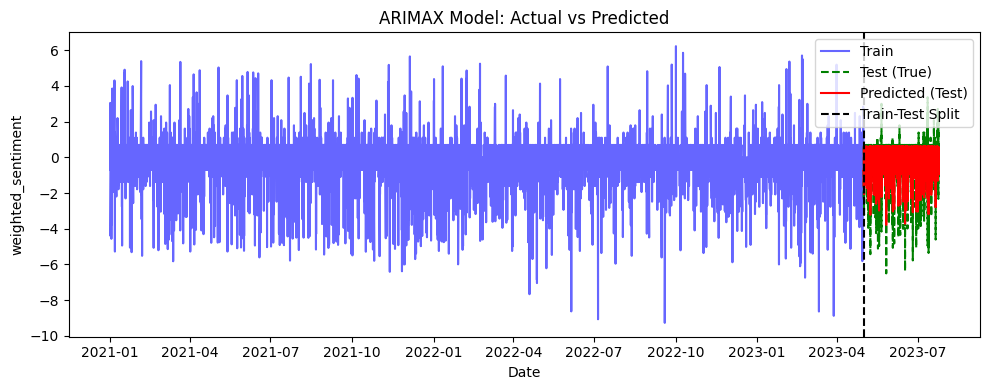

In [ ]:
model_fitted, y_train, y_test, forecast, rmse, mae, r2 = apply_arimax_model(delivery_daily, p=10, d=0, q=6)


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling th

ARIMAX model fitted to predict 'weighted_sentiment'.
RMSE: 0.5869
MAE:  0.3644
R2 Score: 0.2723


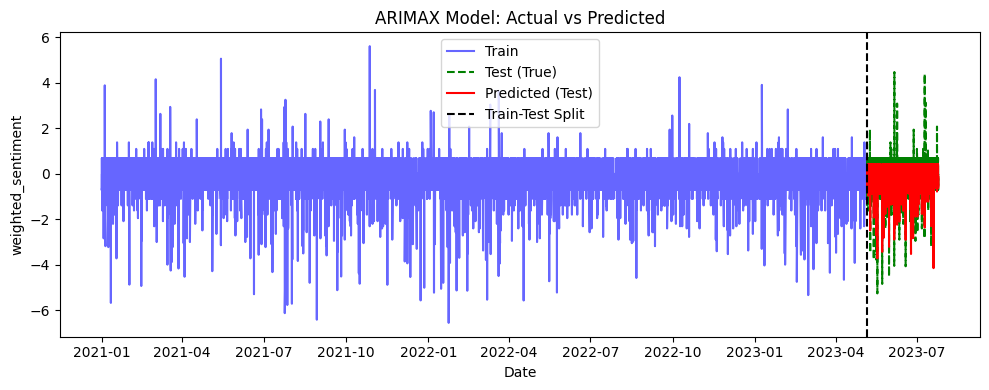

In [ ]:
model_fitted, y_train, y_test, forecast, rmse, mae, r2 = apply_arimax_model(app_experience_daily, p=7, d=0, q=8)


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling th

ARIMAX model fitted to predict 'weighted_sentiment'.
RMSE: 0.3485
MAE:  0.0995
R2 Score: 0.6913


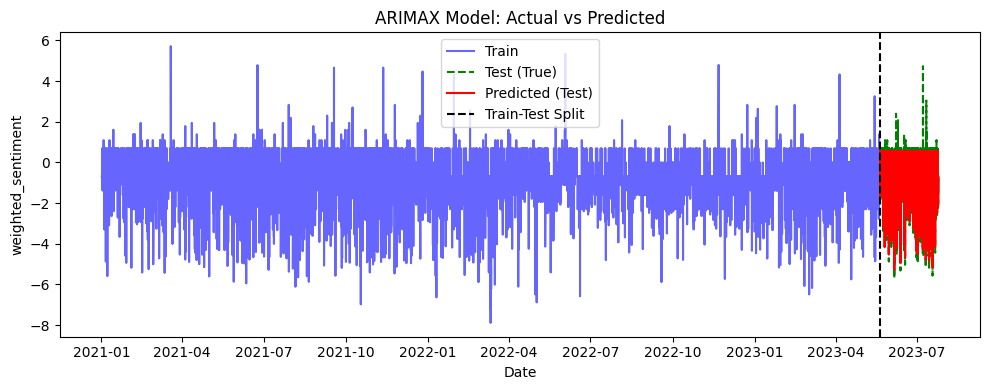

In [ ]:
model_fitted, y_train, y_test, forecast, rmse, mae, r2 = apply_arimax_model(customer_service_daily, p=8, d=0, q=3)


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an int

ARIMAX model fitted to predict 'weighted_sentiment'.
RMSE: 0.2721
MAE:  0.0990
R2 Score: 0.7454


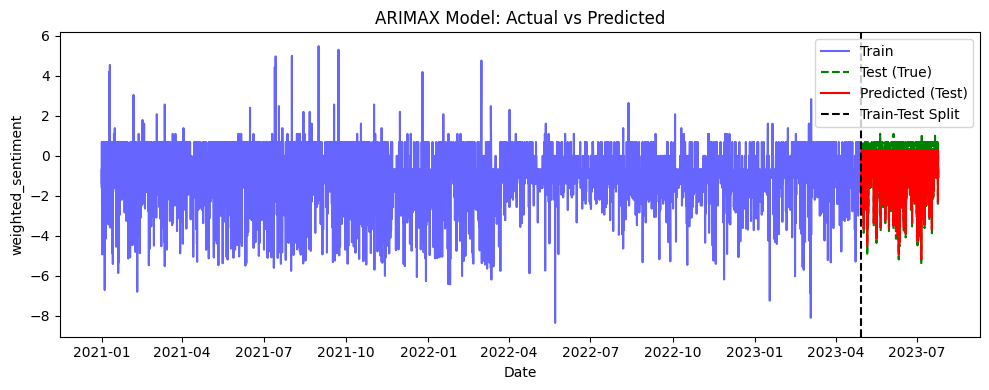

In [ ]:
model_fitted, y_train, y_test, forecast, rmse, mae, r2 = apply_arimax_model(food_quality_daily, p=5, d=0, q=4)


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling th

ARIMAX model fitted to predict 'weighted_sentiment'.
RMSE: 0.3007
MAE:  0.1349
R2 Score: 0.5212


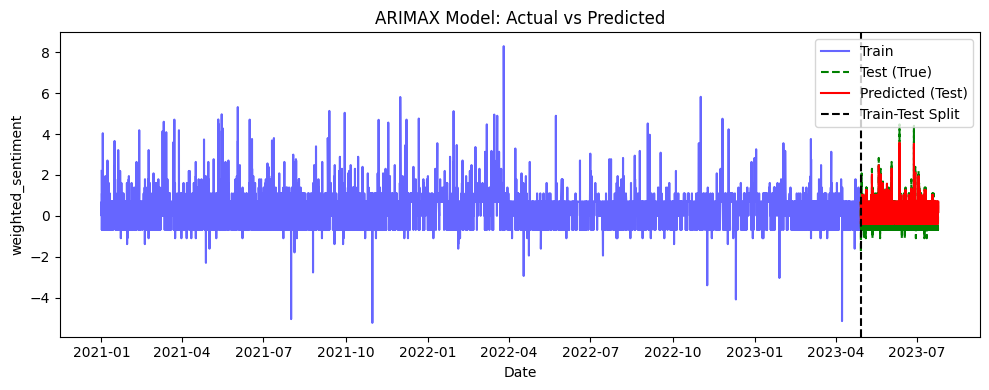

In [ ]:
model_fitted, y_train, y_test, forecast, rmse, mae, r2 = apply_arimax_model(Efficiency_daily, p=5, d=0, q=4)


# RNN

In [ ]:

#### Code for Hypertuning####

'''
window_size = 10
learning_rate = [0.005,0.01]
num_layers = [1,2]
num_neurons = [16,32,64]

# Helper function to create sequences
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

for aspect, data in aspect_dfs.items():
    print(f"\nAspect: {aspect}")
    df = data[['review_date', 'weighted_sentiment']].copy()
    df['review_date'] = pd.to_datetime(df['review_date'])
    df = df.sort_values('review_date')

    sentiment_series = df['weighted_sentiment'].values.reshape(-1, 1).astype(np.float32)

    # Train-test split (no scaling)
    split_index = int(len(sentiment_series) * 0.85)
    train_data = sentiment_series[:split_index]
    test_data = sentiment_series[split_index - window_size:]  # keep some history

    X_train, y_train = create_sequences(train_data, window_size)
    X_test, y_test = create_sequences(test_data, window_size)

    # Reshape for RNN input
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # Define RNN model
    model = Sequential()
    for i in range(num_layers):
        return_seq = i < num_layers - 1
        model.add(SimpleRNN(num_neurons, return_sequences=return_seq, input_shape=(window_size, 1)))
    model.add(Dense(1))

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='mse', optimizer=optimizer)

    # Callback to log every 100 epochs
    class EpochLogger(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs=None):
            if (epoch + 1) % 100 == 0:
                print(f"Epoch {epoch+1}, Loss: {logs['loss']:.4f}")

    model.fit(X_train, y_train, epochs=500, verbose=0, callbacks=[EpochLogger()]) '''

In [ ]:
class RNNModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, num_layers=1):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out

def create_sequences(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

def apply_rnn_pytorch(df, target_col='weighted_sentiment', time_steps=10, split_ratio=0.85,
                      lr=0.005, epochs=500, batch_size=32, device='cpu'):

    if not isinstance(df.index, pd.DatetimeIndex):
        if 'review_date' in df.columns:
            df['review_date'] = pd.to_datetime(df['review_date'])
            df.set_index('review_date', inplace=True)
        elif 'delivery_date' in df.columns:
            df['delivery_date'] = pd.to_datetime(df['delivery_date'])
            df.set_index('delivery_date', inplace=True)
        else:
            raise ValueError("DataFrame must have a datetime column")

    df = df[[target_col]].dropna()
    data = df[target_col].values.astype(np.float32)

    X, y = create_sequences(data, time_steps)
    split = int(len(X) * split_ratio)

    X_train, y_train = X[:split], y[:split]
    X_test, y_test = X[split:], y[split:]

    X_train_tensor = torch.tensor(X_train).unsqueeze(-1).to(device)
    y_train_tensor = torch.tensor(y_train).unsqueeze(-1).to(device)
    X_test_tensor = torch.tensor(X_test).unsqueeze(-1).to(device)
    y_test_tensor = torch.tensor(y_test).unsqueeze(-1).to(device)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    model = RNNModel().to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    model.train()
    for epoch in range(1, epochs + 1):
        total_loss = 0
        for batch_X, batch_y in train_loader:
            output = model(batch_X)
            loss = criterion(output, batch_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        if epoch % 100 == 0:
            avg_loss = total_loss / len(train_loader)
            print(f"Epoch {epoch}/{epochs}, Loss: {avg_loss:.6f}")

    model.eval()
    with torch.no_grad():
        y_pred_tensor = model(X_test_tensor)
        y_pred = y_pred_tensor.cpu().numpy()
        y_true = y_test_tensor.cpu().numpy()

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\nTest RMSE: {rmse:.4f}")
    print(f"Test MAE:  {mae:.4f}")
    print(f"Test R²:   {r2:.4f}")

    return model, rmse, mae, r2



In [ ]:
model, rmse, mae, r2= apply_rnn_pytorch(delivery_daily, target_col='weighted_sentiment')


Epoch 100/500, Loss: 1.129526
Epoch 200/500, Loss: 1.131662
Epoch 300/500, Loss: 1.132358
Epoch 400/500, Loss: 1.134372
Epoch 500/500, Loss: 1.136135

Test RMSE: 0.8639
Test MAE:  0.5953
Test R²:   -0.0364


In [ ]:
model, rmse, mae, r2= apply_rnn_pytorch(app_experience_daily, target_col='weighted_sentiment')


Epoch 100/500, Loss: 0.573106
Epoch 200/500, Loss: 0.567610
Epoch 300/500, Loss: 0.570563
Epoch 400/500, Loss: 0.569758
Epoch 500/500, Loss: 0.571640

Test RMSE: 0.6980
Test MAE:  0.5077
Test R²:   -0.0289


In [ ]:
model, rmse, mae, r2 = apply_rnn_pytorch(customer_service_daily, target_col='weighted_sentiment')


Epoch 100/500, Loss: 0.543267
Epoch 200/500, Loss: 0.543197
Epoch 300/500, Loss: 0.543856
Epoch 400/500, Loss: 0.544458
Epoch 500/500, Loss: 0.545924

Test RMSE: 0.6372
Test MAE:  0.3018
Test R²:   -0.0319


In [ ]:
model, rmse, mae, r2 = apply_rnn_pytorch(food_quality_daily, target_col='weighted_sentiment')


Epoch 100/500, Loss: 0.609865
Epoch 200/500, Loss: 0.612623
Epoch 300/500, Loss: 0.610938
Epoch 400/500, Loss: 0.609614
Epoch 500/500, Loss: 0.608082

Test RMSE: 0.6184
Test MAE:  0.4399
Test R²:   -0.3142


In [ ]:
model, rmse, mae, r2 = apply_rnn_pytorch(Efficiency_daily, target_col='weighted_sentiment')


Epoch 100/500, Loss: 0.205341
Epoch 200/500, Loss: 0.208537
Epoch 300/500, Loss: 0.210845
Epoch 400/500, Loss: 0.210087
Epoch 500/500, Loss: 0.208781

Test RMSE: 0.4349
Test MAE:  0.2531
Test R²:   -0.0013


# LSTM

In [ ]:

### For Hypertunning

'''
def create_sequences(data, window_size):
   X, y = [], []
   for i in range(len(data) - window_size):
       X.append(data[i:i+window_size])
       y.append(data[i+window_size])
   return np.array(X), np.array(y)

# Initialize results dictionary
final_lstm_results = {}

# Hyperparameter options
layer_options = [1, 2]
neuron_options = [32, 64]
learning_rates = [0.005, 0.01]
window_size = 10
# Loop over each aspect
for aspect, data in aspect_dfs.items():
   print(f"\nTraining LSTM for Aspect: {aspect}")

   df = data[['review_date', 'weighted_sentiment']].copy()
   df['review_date'] = pd.to_datetime(df['review_date'])
   df = df.sort_values('review_date')

   # Convert to float32
   sentiment_series = df['weighted_sentiment'].values.reshape(-1, 1).astype(np.float32)

   # Train-test split (85:15)
   split_index = int(len(sentiment_series) * 0.85)
   train_data = sentiment_series[:split_index]
   test_data = sentiment_series[split_index - window_size:]

   # Create sequences
   X_train, y_train = create_sequences(train_data, window_size)
   X_test, y_test = create_sequences(test_data, window_size)

   # Reshape for LSTM input
   X_train = X_train.reshape((X_train.shape[0], window_size, 1))
   X_test = X_test.reshape((X_test.shape[0], window_size, 1))

   best_mse = float('inf')
   best_config = {}
   for num_layers in layer_options:
       for num_neurons in neuron_options:
           for lr in learning_rates:
               print(f"Trying config - Layers: {num_layers}, Neurons: {num_neurons}, LR: {lr}")

               model = Sequential()
               for i in range(num_layers):
                   return_seq = i < num_layers - 1
                   model.add(LSTM(num_neurons, return_sequences=return_seq, input_shape=(window_size, 1)))
               model.add(Dense(1))

               optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
               model.compile(loss='mse', optimizer=optimizer)

               # Logging every 100 epochs
               class EpochLogger(tf.keras.callbacks.Callback):
                   def on_epoch_end(self, epoch, logs=None):
                       if (epoch + 1) % 100 == 0:
                           print(f"   Epoch {epoch+1}, Loss:
{logs['loss']:.4f}")

               model.fit(X_train, y_train, epochs=500, verbose=0, callbacks=[EpochLogger()])

               # Evaluate
               preds = model.predict(X_test)
               mse = mean_squared_error(y_test, preds)

               if mse < best_mse:
                   best_mse = mse
                   best_config = {
                       'layers': num_layers,
                       'neurons': num_neurons, 'learning_rate': lr, 'mse': round(mse, 4) }
final_lstm_results[aspect] = best_config '''

'\ndef create_sequences(data, window_size): \n   X, y = [], [] \n   for i in range(len(data) - window_size): \n       X.append(data[i:i+window_size]) \n       y.append(data[i+window_size]) \n   return np.array(X), np.array(y) \n \n# Initialize results dictionary \nfinal_lstm_results = {} \n \n# Hyperparameter options \nlayer_options = [1, 2] \nneuron_options = [32, 64] \nlearning_rates = [0.005, 0.01] \nwindow_size = 10 \n# Loop over each aspect \nfor aspect, data in aspect_dfs.items(): \n   print(f"\nTraining LSTM for Aspect: {aspect}") \n   \n   df = data[[\'review_date\', \'weighted_sentiment\']].copy() \n   df[\'review_date\'] = pd.to_datetime(df[\'review_date\']) \n   df = df.sort_values(\'review_date\') \n \n   # Convert to float32 \n   sentiment_series = df[\'weighted_sentiment\'].values.reshape(-1, 1).astype(np.float32) \n \n   # Train-test split (85:15) \n   split_index = int(len(sentiment_series) * 0.85) \n   train_data = sentiment_series[:split_index] \n   test_data = sentim

In [ ]:


class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

def create_sequences(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

def apply_lstm_pytorch(df, target_col='weighted_sentiment', time_steps=10, split_ratio=0.85,
                       lr=0.005, epochs=500, batch_size=16, device='cpu'):

    if not isinstance(df.index, pd.DatetimeIndex):
        if 'review_date' in df.columns:
            df['review_date'] = pd.to_datetime(df['review_date'])
            df.set_index('review_date', inplace=True)
        elif 'delivery_date' in df.columns:
            df['delivery_date'] = pd.to_datetime(df['delivery_date'])
            df.set_index('delivery_date', inplace=True)
        else:
            raise ValueError("DataFrame must have a datetime column")

    df = df[[target_col]].dropna()
    data = df[target_col].values.astype(np.float32)

    X, y = create_sequences(data, time_steps)
    split = int(len(X) * split_ratio)

    X_train, y_train = X[:split], y[:split]
    X_test, y_test = X[split:], y[split:]

    X_train_tensor = torch.tensor(X_train).unsqueeze(-1).to(device)
    y_train_tensor = torch.tensor(y_train).unsqueeze(-1).to(device)
    X_test_tensor = torch.tensor(X_test).unsqueeze(-1).to(device)
    y_test_tensor = torch.tensor(y_test).unsqueeze(-1).to(device)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    model = LSTMModel().to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    model.train()
    for epoch in range(1, epochs + 1):
        total_loss = 0
        for batch_X, batch_y in train_loader:
            output = model(batch_X)
            loss = criterion(output, batch_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        if epoch % 100 == 0:
            avg_loss = total_loss / len(train_loader)
            print(f"Epoch {epoch}/{epochs}, Loss: {avg_loss:.6f}")

    model.eval()
    with torch.no_grad():
        y_pred_tensor = model(X_test_tensor)
        y_pred = y_pred_tensor.cpu().numpy()
        y_true = y_test_tensor.cpu().numpy()

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\nTest RMSE: {rmse:.4f}")
    print(f"Test MAE: {mae:.4f}")
    print(f"Test R2 Score: {r2:.4f}")

    return model, rmse, mae, r2



In [ ]:
model, rmse, mae, r2= apply_lstm_pytorch(delivery_daily, target_col='weighted_sentiment')


Epoch 100/500, Loss: 0.955923
Epoch 200/500, Loss: 0.866323
Epoch 300/500, Loss: 0.816292
Epoch 400/500, Loss: 0.811262
Epoch 500/500, Loss: 0.801592

Test RMSE: 0.9124
Test MAE: 0.6229
Test R2 Score: -0.1559


In [ ]:
model, rmse, mae, r2 = apply_lstm_pytorch(app_experience_daily, target_col='weighted_sentiment')


Epoch 100/500, Loss: 0.526394
Epoch 200/500, Loss: 0.466221
Epoch 300/500, Loss: 0.429278
Epoch 400/500, Loss: 0.416766
Epoch 500/500, Loss: 0.404520

Test RMSE: 0.7732
Test MAE: 0.5827
Test R2 Score: -0.2626


In [ ]:
model, rmse, mae,r2 = apply_lstm_pytorch(customer_service_daily, target_col='weighted_sentiment')


Epoch 100/500, Loss: 0.505610
Epoch 200/500, Loss: 0.481676
Epoch 300/500, Loss: 0.470313
Epoch 400/500, Loss: 0.467920
Epoch 500/500, Loss: 0.468320

Test RMSE: 0.6753
Test MAE: 0.3152
Test R2 Score: -0.1590


In [ ]:
model, rmse, mae, r2 = apply_lstm_pytorch(Efficiency_daily, target_col='weighted_sentiment')


Epoch 100/500, Loss: 0.201567
Epoch 200/500, Loss: 0.199137
Epoch 300/500, Loss: 0.194045
Epoch 400/500, Loss: 0.190609
Epoch 500/500, Loss: 0.191721

Test RMSE: 0.4495
Test MAE: 0.2354
Test R2 Score: -0.0699


In [ ]:
model, rmse, mae, r2 = apply_lstm_pytorch(food_quality_daily, target_col='weighted_sentiment')


Epoch 100/500, Loss: 0.594132
Epoch 200/500, Loss: 0.586014
Epoch 300/500, Loss: 0.580246
Epoch 400/500, Loss: 0.564126
Epoch 500/500, Loss: 0.558023

Test RMSE: 0.5639
Test MAE: 0.2515
Test R2 Score: -0.0925


# GRU

In [20]:
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def create_sequences(data, window_size):
    xs, ys = [], []
    for i in range(len(data) - window_size):
        x = data[i:i + window_size]
        y = data[i + window_size]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

class GRUNet(nn.Module):
    def __init__(self, input_size=1, hidden_size=62, num_layers=1):
        super(GRUNet, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])
        return out

def apply_gru_model(df, target_col='weighted_sentiment', window_size=10, epochs=500, lr=0.005):
    if 'review_date' in df.columns:
        df = df.set_index('review_date')

    df = df[[target_col]].dropna()
    data = df.values.astype(np.float32)

    X, y = create_sequences(data, window_size)

    split_index = int(len(X) * 0.85)
    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]
    X_train_tensor = torch.tensor(X_train)
    y_train_tensor = torch.tensor(y_train).unsqueeze(-1)
    X_test_tensor = torch.tensor(X_test)
    y_test_tensor = torch.tensor(y_test).unsqueeze(-1)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

    model = GRUNet()
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses = []

    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            output = model(batch_x)
            loss = criterion(output, batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        if epoch % 100 == 0:
            print(f"Epoch {epoch}/{epochs}, Loss: {avg_loss:.4f}")

    model.eval()
    with torch.no_grad():
        predictions = model(X_test_tensor).squeeze().numpy()
        y_true = y_test_tensor.squeeze().numpy()

    rmse = np.sqrt(mean_squared_error(y_true, predictions))
    mae = mean_absolute_error(y_true, predictions)
    r2 = r2_score(y_true, predictions)

    print(f"\nTest RMSE: {rmse:.4f}")
    print(f"Test MAE: {mae:.4f}")
    print(f"Test R2 Score: {r2:.4f}")

    return model, rmse, mae, r2, train_losses




In [21]:
model, rmse, mae, r2, train_losses = apply_gru_model(delivery_daily, target_col='weighted_sentiment')


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([2, 1, 1])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 100/500, Loss: 1.0920
Epoch 200/500, Loss: 1.0894
Epoch 300/500, Loss: 1.0875
Epoch 400/500, Loss: 1.0867
Epoch 500/500, Loss: 1.0844

Test RMSE: 0.8543
Test MAE: 0.5313
Test R2 Score: -0.0134


In [ ]:
model, rmse, mae,r2, train_losses = apply_gru_model(app_experience_daily, target_col='weighted_sentiment')


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([20, 1, 1])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 100/500, Loss: 0.5513
Epoch 200/500, Loss: 0.5512
Epoch 300/500, Loss: 0.5504
Epoch 400/500, Loss: 0.5506
Epoch 500/500, Loss: 0.5497

Test RMSE: 0.6942
Test MAE: 0.5187
Test R2 Score: -0.0178


In [ ]:
model, rmse, mae,r2,train_losses = apply_gru_model(customer_service_daily, target_col='weighted_sentiment')


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([17, 1, 1])) that is different to the input size (torch.Size([17, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 100/500, Loss: 0.5282
Epoch 200/500, Loss: 0.5281
Epoch 300/500, Loss: 0.5285
Epoch 400/500, Loss: 0.5280
Epoch 500/500, Loss: 0.5287

Test RMSE: 0.6309
Test MAE: 0.2478
Test R2 Score: -0.0115


In [22]:
model, rmse, mae,r2,train_losses = apply_gru_model(Efficiency_daily, target_col='weighted_sentiment')


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([25, 1, 1])) that is different to the input size (torch.Size([25, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 100/500, Loss: 0.2017
Epoch 200/500, Loss: 0.2016
Epoch 300/500, Loss: 0.2016
Epoch 400/500, Loss: 0.2015
Epoch 500/500, Loss: 0.2015

Test RMSE: 0.4369
Test MAE: 0.2713
Test R2 Score: -0.0105


In [23]:
model, rmse, mae,r2, train_losses = apply_gru_model(food_quality_daily, target_col='weighted_sentiment')


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([28, 1, 1])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 100/500, Loss: 0.5925
Epoch 200/500, Loss: 0.5923
Epoch 300/500, Loss: 0.5922
Epoch 400/500, Loss: 0.5919
Epoch 500/500, Loss: 0.5920

Test RMSE: 0.5432
Test MAE: 0.2302
Test R2 Score: -0.0138
